# 9. Neural Networks

The goal of this notebook is to generate a neural network. It will be utilized to classify the complex labels such as Bill Sponsor State or Partisian Affiliation. This notebook complements the project write-up, [posted here](https://nataliermcastro.github.io/projects/2025/04/24/political-stances-neural-networks.html). The code was created for an assignment prior to its use here in an NLP class - much of the credit for this code may be attributed to the scaffolding provided to support students when hand coding a neural network from scratch!


Tested in this notebook will be the paritisan affiliation for both news and bill data in addition to the sponsor state for the bill.

---

## 1. Environment Creation

### 1.1 Library Import 

In [17]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
''' DATA MANAGEMENT '''
import pandas as pd
import numpy as np

''' NATURAL LANGUAGE QUERYING '''
import regex as re

''' NATURAL LANGUAGE TOOLKIT '''
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

''' TENSOR FLOW '''
## Libraries to convert the sequences to tensors
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset


''' EMBEDDING VISUALIZATION '''

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

''' NEURAL NETWORK VISUALIZATION '''
import torch.nn as nn
import torch.optim as optim

''' EVALUATION METRICS '''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

''' DATA VISUALIZATION '''
import seaborn as sb
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import graphviz
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits.mplot3d import Axes3D 
from IPython.display import Image
import pydotplus
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from tabulate import tabulate

''' MODEL VERIFICATION  '''
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


''' SANITY '''
from tqdm import tqdm

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1.2 Function Definition:

**Preprocess**: Used in 1.3.1

In [2]:
def preprocess(text : str) -> list:
    ## first, converting the string into a list format
    text_ = text.split()
    
    text_storage = []
    ## using the wordnet lemmatizer to lemmatize the words
    for word in text_:
        lemma = lemmatizer.lemmatize(word)
        text_storage.append(lemma)
        
    ## removing all of the punctuation, special characters, digits, and trailing spaces using RegEx
    text_for_cleaning = ' '.join(text_storage)
    clean_text = re.sub('[!@#$%^&*()_+\'",.?*-+:;<>~`0-9]',' ',text_for_cleaning)
    stripped_text = clean_text.strip()
    
    ##splitting the string back into a list 
    preprocessed_text = stripped_text.split()
    
    ## returning the the final processed text
    return (preprocessed_text[0:200])

In [3]:
# Convert the dataset into sequences of indices
def document_to_sequence(document : str, token2index) -> list:
    return [token2index[token] for token in document]

In [4]:
# Truncate the sequences
def pad_sequence(sequence: list, max_length: int, padding_token: int = 0) -> list:
    ## checking to see the length of the token 
    sequence_length = len(sequence)
    #print (sequence)
    #print (sequence_length)
    
    ## creating an if / else statement to check if it is above or below with the length.
    if sequence_length >= max_length:
        ## if the sequence length is above, it is truncated and only the first n for the max sequence are returned
        truncated_sequence = sequence[0:max_length]
        
        return (truncated_sequence)

    ## else: the pad token is appended onto the end until it is the max sequence
    else:
        
        ## finds the difference between the length of the sequence and the max length
        difference = max_length - sequence_length
 
        # generating a list with the length of the difference
        padded_list = ['[PAD]'] * difference
   
        ## extending the sequence with the pad values
        padded_sequence = sequence.extend(padded_list)
        ## returning the list
        return (padded_sequence)

In [5]:
# Truncate the sequences, and adding zero instead of the pad token
def pad_sequence_zeros(sequence: list, max_length: int, padding_token: int = 0) -> list:
    ## checking to see the length of the token 
    sequence_length = len(sequence)
    #print (sequence)
    #print (sequence_length)
    
    ## creating an if / else statement to check if it is above or below with the length.
    if sequence_length >= max_length:
        ## if the sequence length is above, it is truncated and only the first n for the max sequence are returned
        truncated_sequence = sequence[0:max_length]
        
        return (truncated_sequence)

    ## else: the pad token is appended onto the end until it is the max sequence
    else:
        
        ## finds the difference between the length of the sequence and the max length
        difference = max_length - sequence_length
 
        # generating a list with the length of the difference
        padded_list = [0] * difference
   
        ## extending the sequence with the pad values
        padded_sequence = sequence.extend(padded_list)
        ## returning the list
        return (padded_sequence)

In [7]:
def get_tensor_size(tensor_dataset):
    length = 0
    for i in tensor_dataset:
        length = length + 1
        
    print (f"The length of the dataset is {length}.")

### 1.3 Data Import

In [6]:
news_data_raw = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\News Data Cleaned.csv")

In [60]:
bills_data_raw = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\Bill Information Full FINAL.csv")

In [8]:
news_data_raw = news_data_raw[['Party','publisher','title', 'description']].copy()
news_data_raw['title + description'] = news_data_raw['title'] + news_data_raw['description']

In [61]:
bills_data_raw = bills_data_raw[['Bill Type','Sponser Affiliation','Sponser State','Committees','Bill Text']]

In [9]:
news_data_raw.head(2)

,Party,publisher,title,description,title + description
0,Republican,The Verge,Trump’s first 100 days: all the news impacting...,"President Donald Trump is taking on TikTok, el...",Trump’s first 100 days: all the news impacting...
1,Republican,Gizmodo.com,The Quiet Death of Biden’s Climate Corps—and W...,Biden's green jobs program was never what it s...,The Quiet Death of Biden’s Climate Corps—and W...


In [15]:
bills_data_raw.head(2)

,Bill Type,Sponser Affiliation,Sponser State,Committees,Bill Text
0,hr,D,HI,"House - Natural Resources, Agriculture | Senat...",\n\n119 HR 375 : Continued Rapid Ohia Death Re...
1,hr,R,NY,House - Agriculture,\n\n119 HR 349 IH: Goldie’s Act\nU.S. House of...


In [16]:
print (f"The length of the sequences for the Bill Text is: {len(bills_data_raw)}")

The length of the sequences for the Bill Text is: 3261


## 2. Data Processing

A neural network needs (relatively) preprocessed data that is clean. The punctuation and numbers will be removed.

### 2.1 Data Preparation
#### 2.1.1. Data Cleaning

In [10]:
''' pre-processing the documents'''

## NEWS
preprocessed_documents_news = news_data_raw['title + description'].apply(preprocess)
print(f'Number of preprocessed documents: {len(preprocessed_documents_news)}')
print(preprocessed_documents_news.head())

Number of preprocessed documents: 819
0    [Trump’s, first, days, all, the, news, impacti...
1    [The, Quiet, Death, of, Biden’s, Climate, Corp...
2    [The, peanut, farmer, who, rose, to, US, presi...
3    [Confident, organised, still, freewheeling, Tr...
4    [Thousands, protest, against, Trump, in, Washi...
Name: title + description, dtype: object


In [62]:
## BILLS
preprocessed_documents_bills = bills_data_raw['Bill Text'].apply(preprocess)
print(f'Number of preprocessed documents: {len(preprocessed_documents_bills)}')
print(preprocessed_documents_bills.head())

Number of preprocessed documents: 3261
0    [HR, Continued, Rapid, Ohia, Death, Response, ...
1    [HR, IH, Goldie’s, Act, U, S, House, of, Repre...
2    [HR, IH, Natural, Gas, Tax, Repeal, Act, U, S,...
3    [HR, IH, Long, Island, Sound, Restoration, and...
4    [HR, IH, Great, Lakes, Restoration, Initiative...
Name: Bill Text, dtype: object


#### 2.1.2 Embedding Layer Generation

This secion of the code is indexing all of the words in the data sets and then generating a set for each data type

In [11]:
''' NEWS DATA '''
# Make a token2index dictionary and a index2token dictionary and convert the documents to sequences of indices
token2index_news = {}
index2token_news = {}
saved_tokens_news = []
index = 1 # reserve 0 for padding
for document in preprocessed_documents_news:
    for token in document:

        ## checking to see if the token is currently in the list of keys 
        if token in saved_tokens_news:
        ## if it is pass
            pass
        
        ## if the token is not currently in the list of keys
        if token not in saved_tokens_news:
            ## saving the token to iterate through
            saved_tokens_news.append(token)
            ## create a new key in the dictionary and adding the index
            token2index_news[token] = index
            ## adding one to the index
            index = index + 1
            
## once the disctionary has been generated, converting the token2index to the index2token dictionary
index2token_news = {k:v for k,v in zip(token2index_news.values(),token2index_news.keys())}

token2index_news['[PAD]'] = 0
index2token_news[0] = '[PAD]'

print(f'Number of unique tokens: {len(token2index_news)}')

Number of unique tokens: 7729


In [63]:
''' BILLS DATA '''
# Make a token2index dictionary and a index2token dictionary and convert the documents to sequences of indices
token2index_bills = {}
index2token_bills = {}
saved_tokens_bills = []
index = 1 # reserve 0 for padding
for document in preprocessed_documents_bills:
    for token in document:

        ## checking to see if the token is currently in the list of keys 
        if token in saved_tokens_bills:
        ## if it is pass
            pass
        
        ## if the token is not currently in the list of keys
        if token not in saved_tokens_bills:
            ## saving the token to iterate through
            saved_tokens_bills.append(token)
            ## create a new key in the dictionary and adding the index
            token2index_bills[token] = index
            ## adding one to the index
            index = index + 1
            
## once the disctionary has been generated, converting the token2index to the index2token dictionary
index2token_bills = {k:v for k,v in zip(token2index_bills.values(),token2index_bills.keys())}

token2index_bills['[PAD]'] = 0
index2token_bills[0] = '[PAD]'

print(f'Number of unique tokens: {len(token2index_bills)}')

Number of unique tokens: 12268


#### 2.1.3 Sequence Generation + Padding

Now, it is time to generate the embeddings for the sequence, it will also be padded (adding a bunch of zeros) in order to account for vector shape later on in preprocessing

In [12]:
''' GENERATING THE SEQUENCES: NEWS'''
sequences_news = preprocessed_documents_news.apply(lambda x: document_to_sequence(x, token2index_news))
print(sequences_news.head()) # should now be a list of indices

0    [1, 2, 3, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, 13,...
1    [34, 35, 36, 31, 37, 38, 39, 40, 41, 42, 43, 4...
2    [34, 57, 58, 59, 60, 61, 62, 63, 19, 64, 65, 6...
3    [79, 80, 81, 82, 11, 83, 84, 85, 86, 87, 1, 2,...
4    [98, 99, 100, 11, 21, 101, 55, 102, 103, 104, ...
Name: title + description, dtype: object


In [64]:
''' GENERATING THE SEQUENCES: BILLS'''
sequences_bills = preprocessed_documents_bills.apply(lambda x: document_to_sequence(x, token2index_bills))
print(sequences_bills.head()) # should now be a list of indices

0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 8, 12, 13,...
1    [1, 107, 108, 7, 9, 10, 11, 8, 12, 13, 13, 14,...
2    [1, 107, 168, 169, 170, 171, 7, 9, 10, 11, 8, ...
3    [1, 107, 207, 208, 209, 210, 31, 211, 212, 7, ...
4    [1, 107, 252, 253, 210, 254, 7, 8, 9, 10, 11, ...
Name: Bill Text, dtype: object


In [13]:
''' QUICK EDA TO SEE WHAT AN APPROPRIATE PAD LENGTH IS '''

def average_text_length(text_list):
    return sum(len(str(text)) for text in text_list if text is not None) / len(text_list)


In [14]:
print(f"The average token length for News: {average_text_length(preprocessed_documents_news)}")

The average token length for News: 380.6923076923077


In [65]:
print(f"The average token length for Bills: {average_text_length(preprocessed_documents_bills)}")

The average token length for Bills: 1626.603802514566


In [18]:
''' PADDING THE NEWS SEQUENCES
note: this sometimes takes two times to run, so if it shows up as None, just run in one more time :)'''
# Maximum sequence length
max_length = 200

# Truncate the sequences
truncated_sequences_news = [pad_sequence(seq, max_length) for seq in sequences_news]

#truncated_sequences_news = pd.DataFrame(sequences_news).apply(lambda x: pad_sequence(x, max_length))
print(truncated_sequences_news[0:1][0:100])

truncated_sequences_news = np.array(truncated_sequences_news)

[[1, 2, 3, 4, 5, 6, 7, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2, 23, 21, 24, 25, 26, 27, 28, 29, 5, 30, 31, 32, 8, 33, '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [72]:
''' PADDING THE NEWS SEQUENCES
note: this sometimes takes two times to run, so if it shows up as None, just run in one more time :)'''
# Maximum sequence length
max_length = 200

# Truncate the sequences
truncated_sequences_bills = [pad_sequence(seq, max_length) for seq in sequences_bills]

print(truncated_sequences_bills[0:1][0:100])

truncated_sequences_bills = np.array(truncated_sequences_bills)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 8, 12, 13, 13, 14, 15, 16, 17, 18, 19, 8, 20, 21, 22, 23, 24, 25, 26, 27, 28, 17, 29, 30, 31, 26, 32, 20, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 42, 45, 46, 47, 48, 49, 31, 50, 17, 20, 51, 52, 53, 54, 31, 55, 56, 57, 20, 58, 8, 20, 59, 17, 60, 31, 61, 62, 20, 58, 8, 53, 31, 20, 63, 8, 64, 17, 65, 3, 4, 5, 31, 66, 67, 68, 69, 70, 7, 71, 72, 73, 74, 20, 2, 3, 4, 5, 6, 7, 8, 75, 24, 7, 3, 4, 76, 77, 3, 4, 5, 78, 20, 79, 80, 81, 20, 82, 83, 84, 74, 85, 86, 87, 88, 20, 89, 8, 20, 90, 91, 92, 93, 77, 63, 78, 20, 63, 8, 64, 94, 58, 8, 20, 59, 95, 60, 31, 61, 62, 20, 58, 8, 53, 31, 20, 63, 17, 65, 3, 4, 5, 96, 97, 74, 98, 58, 8, 20, 59, 99, 100, 20, 101, 8, 20, 21, 22, 102, 103, 31, 20, 104, 8, 20, 105, 106, 99, 100, 20]]


### 2.2 Converting the Data Into X and Y Tensors

In [19]:
''' TRUNCATING THE SEQUENCES '''

## News
truncated_sequences_int_news = [
    [0 if item == '[PAD]' else int(item) for item in seq]
    for seq in truncated_sequences_news
]


In [73]:
## Bills
truncated_sequences_int_bills= [
    [0 if item == '[PAD]' else int(item) for item in seq]
    for seq in truncated_sequences_bills
]


#### 2.2.1 Storing The Labels & Encoding the Labels

[Label Encoder Documentation on SciKit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [20]:
''' NEWS LABELS '''
labels_full_news_party = news_data_raw['Party'].to_list()
label_encoder = LabelEncoder()
labels_full_news_party = label_encoder.fit_transform(labels_full_news_party)


In [21]:
print (len(sequences_news))
print (len(truncated_sequences_news))
print(len(truncated_sequences_int_news))
print(len(labels_full_news_party))

819
819
819
819


**Note** These cells should be run separately, as the label encoder is used later for visualization

In [75]:
labels_full_bills_party = bills_data_raw['Sponser Affiliation'].to_list()
label_encoder = LabelEncoder()
labels_full_bills_party = label_encoder.fit_transform(labels_full_bills_party)

In [74]:
''' RUN THIS CELL WHEN WORKING FOR STATES '''
labels_full_bills_state = bills_data_raw['Sponser State'].to_list()
label_encoder = LabelEncoder()
labels_full_bills_state = label_encoder.fit_transform(labels_full_bills_state)

In [26]:
print (len(sequences_bills))
print (len(truncated_sequences_bills))
print (len(truncated_sequences_int_bills))
print (len(labels_full_bills_party))
print (len(labels_full_bills_state))

3261
3261
3261
3261
3261


#### 2.2.2 Generating Train, Test, and Validation Splits

In [28]:
''' NEWS'''
X_train_news, X_test_and_val_news, y_label_train_news, y_label_test_and_val_news = train_test_split(truncated_sequences_int_news, labels_full_news_party, test_size=0.2, random_state=123)
X_test_news, X_val_news, y_test_label_news, y_val_label_news = train_test_split(X_test_and_val_news, y_label_test_and_val_news, test_size=0.5, random_state=42)


In [76]:
''' BILLS '''

## Partisan Affiliation
X_train_bills_party, X_test_and_val_bills_party, y_label_train_bills_party, y_label_test_and_val_bills_party = train_test_split(truncated_sequences_int_bills, labels_full_bills_party, test_size=0.2, random_state=123)
X_test_bills_party, X_val_bills_party, y_test_label_bills_party, y_val_label_bills_party = train_test_split(X_test_and_val_bills_party, y_label_test_and_val_bills_party, test_size=0.5, random_state=42)

In [145]:
## Bill Sponsor State
X_train_bills_state, X_test_and_val_bills_state, y_label_train_bills_state, y_label_test_and_val_bills_state = train_test_split(truncated_sequences_int_bills, labels_full_bills_state, test_size=0.2, random_state=123)
X_test_bills_state, X_val_bills_state, y_test_label_bills_state, y_val_label_bills_state = train_test_split(X_test_and_val_bills_state, y_label_test_and_val_bills_state, test_size=0.5, random_state=42)

#### 2.2.4 Turning The Vectors Into Tensors

In [52]:
X_train_news[0][0:20]

[40,
 168,
 169,
 170,
 171,
 55,
 5,
 172,
 173,
 19,
 174,
 50,
 175,
 176,
 177,
 178,
 29,
 179,
 18,
 162]

In [70]:
X_train_bills_party[0][0:20]

[7835,
 74,
 7836,
 7837,
 7838,
 6967,
 7839,
 7840,
 7841,
 2723,
 7842,
 7843,
 7844,
 7845,
 7846,
 7847,
 7848,
 7849,
 7850,
 7851]

In [29]:
# Convert the vectorized reviews to numpy arrays

''' NEWS: PARTISIAN AFFILIATION '''
X_train_news = torch.tensor(list(X_train_news))
X_val_news = torch.tensor(list(X_val_news))
X_test_news = torch.tensor(list(X_test_news))

y_label_train_news_party = torch.tensor(list(y_label_train_news))
y_label_val_news_party = torch.tensor(list(y_val_label_news))
y_label_test_news_party = torch.tensor(list(y_test_label_news))


In [77]:
''' BILLS: PARTISIAN AFFILIATION '''
X_train_bills_party = torch.tensor(list(X_train_bills_party))
X_val_bills_party = torch.tensor(list(X_val_bills_party))
X_test_bills_party = torch.tensor(list(X_test_bills_party))
y_label_train_bills_party = torch.tensor(y_label_train_bills_party)
y_label_val_bills_party = torch.tensor(y_val_label_bills_party)
y_label_test_bills_party = torch.tensor(y_test_label_bills_party)

In [147]:
''' BILLS: SPONSOR STATE'''
X_train_bills_state = torch.tensor(list(X_train_bills_state))
X_val_bills_state = torch.tensor(list(X_val_bills_state))
X_test_bills_state = torch.tensor(list(X_test_bills_state))
y_label_train_bills_state = torch.tensor(y_label_train_bills_state)
y_label_val_bills_state = torch.tensor(y_val_label_bills_state)
y_label_test_bills_state = torch.tensor(y_val_label_bills_state)

#### 2.2.5 Defining the Dataset Class + Dataloader

In [30]:
print (len(X_train_news))
print (len(y_label_train_news_party))

655
655


In [39]:
print (len(X_train_bills_party))
print (len(y_label_train_bills_party))

2608
2608


In [42]:
print (len(X_train_bills_state))
print (len(y_label_train_bills_state))

print (len(X_test_bills_state))
print (len(y_label_test_bills_state))

2608
2608
326
327


In [31]:
''' NEWS '''
# Define the dataset class
train_data_news = TensorDataset(X_train_news, y_label_train_news_party)
val_data_news = TensorDataset(X_val_news, y_label_val_news_party)
test_data_news = TensorDataset(X_test_news, y_label_test_news_party)

# Define the dataloader
batch_size = 16
train_loader_news = DataLoader(train_data_news, batch_size=batch_size)
val_loader_news = DataLoader(val_data_news, batch_size=batch_size)
test_loader_news = DataLoader(test_data_news, batch_size=len(test_data_news))

In [78]:
''' BILLS: PARTISIAN AFFILIATION '''
# Define the dataset class
train_data_bills_party = TensorDataset(X_train_bills_party, y_label_train_bills_party)
val_data_bills_party = TensorDataset(X_val_bills_party, y_label_val_bills_party)
test_data_bills_party = TensorDataset(X_test_bills_party, y_label_test_bills_party)

# Define the dataloader
batch_size = 16
train_loader_bills_party = DataLoader(train_data_bills_party, batch_size=batch_size)
val_loader_bills_party = DataLoader(val_data_bills_party, batch_size=batch_size)
test_loader_bills_party = DataLoader(test_data_bills_party, batch_size=len(test_data_bills_party))

In [148]:
''' BILLS: SPONSOR STATE '''
## Fixing a label issue first
y_label_test_bills_state = y_label_test_bills_state[:len(X_test_bills_state)]

# Define the dataset class
train_data_bills_state = TensorDataset(X_train_bills_state, y_label_train_bills_state)
val_data_bills_state = TensorDataset(X_val_bills_state, y_label_val_bills_state)
test_data_bills_state = TensorDataset(X_test_bills_state, y_label_test_bills_state)

# Define the dataloader
batch_size = 16
train_loader_bills_state = DataLoader(train_data_bills_state, batch_size=batch_size)
val_loader_bills_state = DataLoader(val_data_bills_state, batch_size=batch_size)
test_loader_bills_state = DataLoader(test_data_bills_state, batch_size=len(test_data_bills_state))

In [56]:
''' EXAMINING THE TENSORS:'''

get_tensor_size(train_data_news)
get_tensor_size(val_data_news)
get_tensor_size(test_data_news)

train_data_news.tensors

The length of the dataset is 655.
The length of the dataset is 82.
The length of the dataset is 82.


(tensor([[  40,  168,  169,  ...,    0,    0,    0],
         [2784,  115,   77,  ...,    0,    0,    0],
         [  11, 3606,  407,  ...,    0,    0,    0],
         ...,
         [1116,    5, 1117,  ...,    0,    0,    0],
         [ 989,   11, 3181,  ...,    0,    0,    0],
         [  62, 1296, 5246,  ...,    0,    0,    0]]),
 tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
         0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
         1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
         0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
         1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
         1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
         0, 1, 1, 

In [46]:
get_tensor_size(train_data_bills_party)
get_tensor_size(val_data_bills_party)
get_tensor_size(test_data_bills_party)

train_data_bills_party.tensors

The length of the dataset is 2608.
The length of the dataset is 327.
The length of the dataset is 326.


(tensor([[7.8350e+03, 7.4000e+01, 7.8360e+03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [5.7900e+02, 1.0700e+02, 5.8000e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 1.0700e+02, 3.4300e+02,  ..., 1.0000e+01, 1.4200e+02,
          8.5170e+03],
         ...,
         [1.0900e+02, 3.6000e+01, 3.7000e+01,  ..., 1.0610e+03, 2.0300e+03,
          8.6000e+02],
         [1.0000e+00, 1.0700e+02, 1.6730e+03,  ..., 2.5760e+03, 3.1000e+01,
          2.5770e+03],
         [7.8350e+03, 7.4000e+01, 7.8360e+03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([0, 2, 0,  ..., 0, 2, 0]))

In [49]:
get_tensor_size(train_data_bills_state)
get_tensor_size(val_data_bills_state)
get_tensor_size(test_data_bills_state)

train_data_bills_state.tensors

The length of the dataset is 2608.
The length of the dataset is 327.
The length of the dataset is 326.


(tensor([[7.8350e+03, 7.4000e+01, 7.8360e+03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [5.7900e+02, 1.0700e+02, 5.8000e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 1.0700e+02, 3.4300e+02,  ..., 1.0000e+01, 1.4200e+02,
          8.5170e+03],
         ...,
         [1.0900e+02, 3.6000e+01, 3.7000e+01,  ..., 1.0610e+03, 2.0300e+03,
          8.6000e+02],
         [1.0000e+00, 1.0700e+02, 1.6730e+03,  ..., 2.5760e+03, 3.1000e+01,
          2.5770e+03],
         [7.8350e+03, 7.4000e+01, 7.8360e+03,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([13, 44, 24,  ..., 21,  9, 39]))

## 3. Training The Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_embeddings: int, embedding_dim: int, 
                 padding_idx: int = 0, pretrained_embeddings: torch.Tensor = None, freeze_embeddings: bool = False):
        super(Net, self).__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=padding_idx, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=padding_idx)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1) 
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        
        return (x)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def training_loop(token2index, train_loader, val_loader, d=50, h=50, batch_size=16, num_epochs=5, learning_rate=0.2, n_classes=1):
    ''' INTIALIZING GRAPH STYLE '''
    sb.set_style("white")
    sb.set(font='Times New Roman', font_scale=1)
    fig, ax = plt.subplots(figsize=(6, 4)) 
    ax.set_facecolor('white')
    
    ''' INITIALIZE MODEL '''
    model = Net(
        input_size=d,
        output_size=n_classes,  # Set to 1 for binary classification
        hidden_size=h,
        num_embeddings=len(token2index),
        embedding_dim=d,
        padding_idx=0
    )

    print("📌 Model Parameters:")
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(3, 0.01)

    # Loss function setup
    criterion = nn.BCEWithLogitsLoss() if n_classes == 1 else nn.CrossEntropyLoss()

    # Initialize lists to store loss data for plotting
    training_losses = []
    validation_losses = []

    for epoch in tqdm(range(num_epochs), desc='🐛... | model is inching through the epochs', unit = 'epoch'):
        #print(f"\n\nMODEL TRAINING ------------------\nEPOCH: {epoch}")
        model.train(True)
        train_loss = 0

        for X, y in train_loader:
            if n_classes == 1:
                y = y.unsqueeze(1).float()
            y_hat = model(X)

            loss = criterion(y_hat, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        val_losses = []

        with torch.no_grad():
            for input_, target in val_loader:
                if n_classes == 1:
                    target = target.unsqueeze(1).float()
                predictions = model(input_)
                val_loss_batch = criterion(predictions, target)
                val_losses.append(val_loss_batch.item())

        val_loss = sum(val_losses) / len(val_losses)

        # Store losses for plotting
        training_losses.append(train_loss / len(train_loader))
        validation_losses.append(val_loss)

        '''print('Training loss: %.4f' % (train_loss / len(train_loader)))
        print('Validation loss: %.4f' % val_loss)'''

        if early_stopper.early_stop(val_loss):
            break

    print('----------------------------------------')
    print(f"Final training loss: {train_loss / len(train_loader):.4f}")
    print("The average epoch training loss is:")
    print('Avg train loss:', sum(validation_losses) / len(validation_losses))
    
    # Prepare data for plotting
    epoch_data = pd.DataFrame({
        'Epoch': list(range(1, len(training_losses) + 1)),
        'Training Loss': training_losses,
        'Validation Loss': validation_losses
    })

    # Plot the loss values
    sb.lineplot(data=epoch_data, x='Epoch', y='Training Loss', label='Training Loss')
    sb.lineplot(data=epoch_data, x='Epoch', y='Validation Loss', label='Validation Loss')

    plt.title(f"Training Loss over Epochs\nLearning Rate: {learning_rate} | Batch Size: {batch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    legend = plt.legend()
    legend.get_frame().set_linewidth(.2)  
    legend.get_frame().set_edgecolor('black')  
    legend.get_frame().set_facecolor('none')
    plt.tight_layout()
    plt.show()

    return model


In [ ]:
def evaluation(model, test_loader):
    for batch in test_loader:
        test_inputs, test_targets = batch
        with torch.no_grad():
            test_outputs = model(test_inputs)
        
        predictions = test_outputs.view(-1)
        predictions = torch.tensor([1 if x >= 0.5 else 0 for x in predictions])
    
        accuracy = accuracy_score(test_targets, predictions)
        precision = precision_score(test_targets, predictions)
        recall = recall_score(test_targets, predictions)
        f1 = f1_score(test_targets, predictions)
        
        print(f'accuracy: {accuracy}')
        print(f'precision: {precision}')
        print(f'recall: {recall}')
        print(f'f1: {f1}')
        

    return (predictions, test_targets, accuracy, precision, recall, f1 )

In [ ]:

def visual_confusion_matrix(labels, predictions ,title, label_name, file_name, fig_x, fig_y):
    sb.set_style("white")
    sb.set(font='Times New Roman', font_scale=1)
    fig, ax = plt.subplots(figsize=(fig_x, fig_y)) 
    ax.set_facecolor('white')


    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()

    unique_labels = sorted(set(labels) | set(predictions))
    
    text_labels = list(label_encoder.inverse_transform(unique_labels))
        
    matrix_ = confusion_matrix(labels, predictions, labels = unique_labels)
    confusion_df = pd.DataFrame(matrix_, index=unique_labels, columns=unique_labels)
        
    
    sb.heatmap(confusion_df, annot = True, fmt='d', xticklabels=text_labels, yticklabels=text_labels, cbar_kws={'shrink': 0.5}, ax=ax)
    ax.set_title(f"Confusion Matrix:\n{title}\nLabels: {label_name}")
    ax.set_ylabel("True Labels")
    ax.set_xlabel("Predicted Labels")
    
    ax.set_aspect('equal', adjustable='box')
    #plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    
    # Save and show the plot
    
    plt.tight_layout(pad=.5)
    plt.savefig(file_name, dpi=600)
    
    plt.show()

### 3.1 News Data

#### TEST: 1 d=50, h=50, batch_size = 8, num_epochs = 500, learning_rate = 0.2, n_classes =1 

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 50, padding_idx=0)
  (linear1): Linear(in_features=50, out_features=50, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs:   1%|▏                                 | 3/500 [00:01<04:25,  1.87epoch/s]


----------------------------------------
Final training loss: 0.8642
The average epoch training loss is:
Avg train loss: 0.8222955986857415


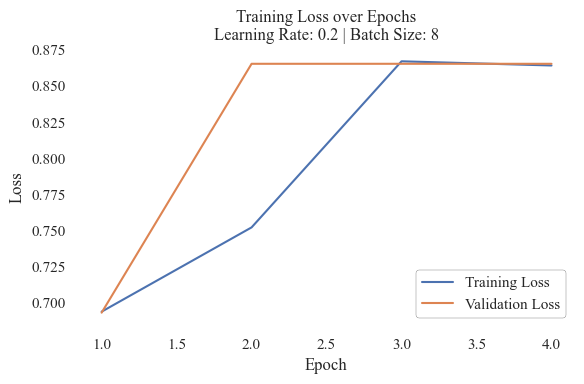

In [95]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=50, h=50, batch_size = 8, num_epochs = 500, learning_rate = 0.2, n_classes =1 )

In [96]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.47560975609756095
precision: 0.47560975609756095
recall: 1.0
f1: 0.6446280991735537


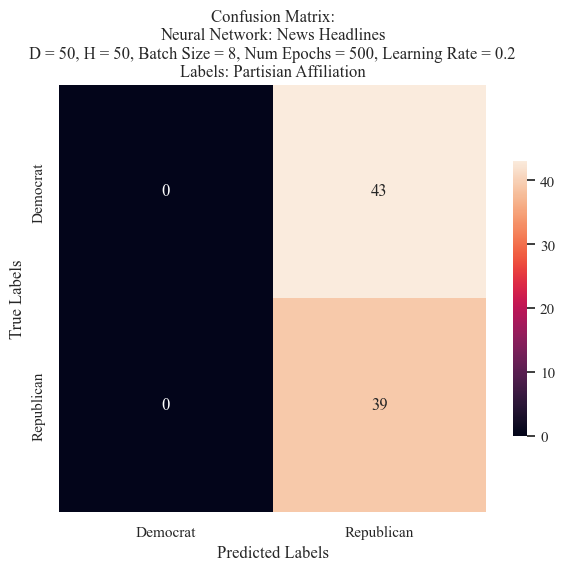

In [97]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 50, H = 50, Batch Size = 8, Num Epochs = 500, Learning Rate = 0.2', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 2: d=50, h=50, batch_size = 4, num_epochs = 100, learning_rate = 0.005, n_classes =1

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 50, padding_idx=0)
  (linear1): Linear(in_features=50, out_features=50, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs:  23%|███████▌                         | 23/100 [00:08<00:27,  2.82epoch/s]


----------------------------------------
Final training loss: 0.5487
The average epoch training loss is:
Avg train loss: 0.6896629714303547


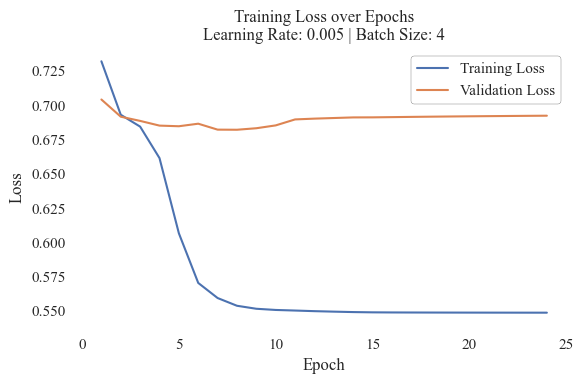

In [98]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=50, h=50, batch_size = 4, num_epochs = 100, learning_rate = 0.005, n_classes =1 )

In [99]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.5975609756097561
precision: 0.6153846153846154
recall: 0.41025641025641024
f1: 0.49230769230769234


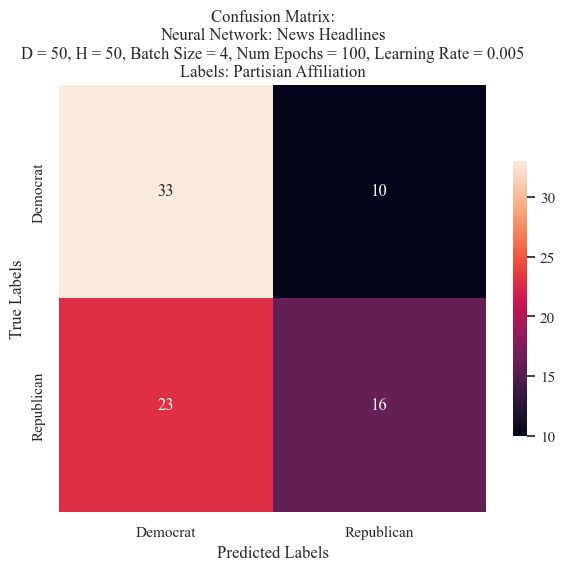

In [100]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 50, H = 50, Batch Size = 4, Num Epochs = 100, Learning Rate = 0.005', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 3: d=500, h=500, batch_size = 4, num_epochs = 100, learning_rate = 0.005, n_classes =1 

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs: 100%|████████████████████████████████| 100/100 [02:26<00:00,  1.46s/epoch]


----------------------------------------
Final training loss: 0.5507
The average epoch training loss is:
Avg train loss: 0.6796883945663766


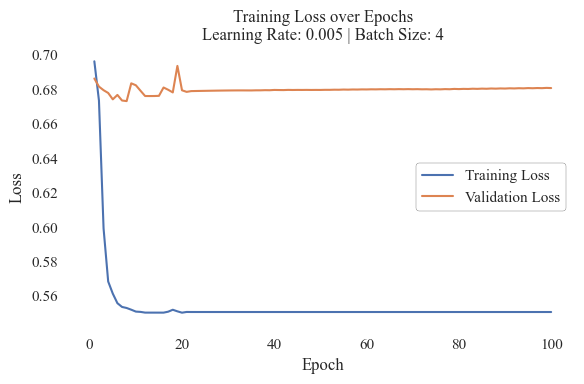

In [110]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=500, h=500, batch_size = 4, num_epochs = 100, learning_rate = 0.005, n_classes =1 )

In [111]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.573170731707317
precision: 0.5625
recall: 0.46153846153846156
f1: 0.5070422535211268


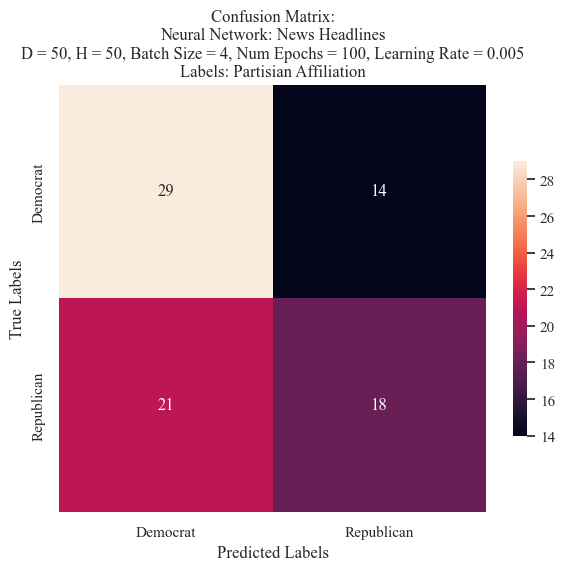

In [112]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 4, Num Epochs = 100, Learning Rate = 0.005', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 4: d=500, h=500, batch_size = 4, num_epochs = 100, learning_rate = 0.0005, n_classes =1

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs:  18%|█████▉                           | 18/100 [00:27<02:05,  1.53s/epoch]


----------------------------------------
Final training loss: 0.5512
The average epoch training loss is:
Avg train loss: 0.68037821901472


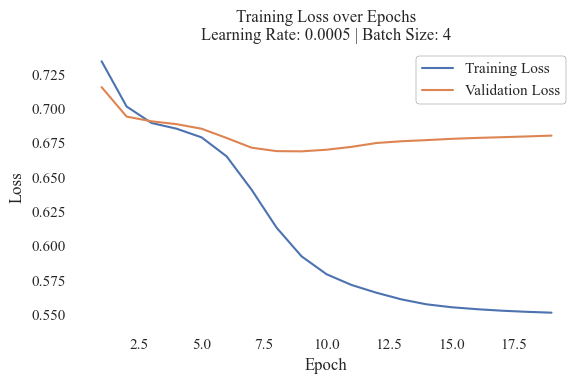

In [113]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=500, h=500, batch_size = 4, num_epochs = 100, learning_rate = 0.0005, n_classes =1 )

In [114]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.5975609756097561
precision: 0.59375
recall: 0.48717948717948717
f1: 0.5352112676056338


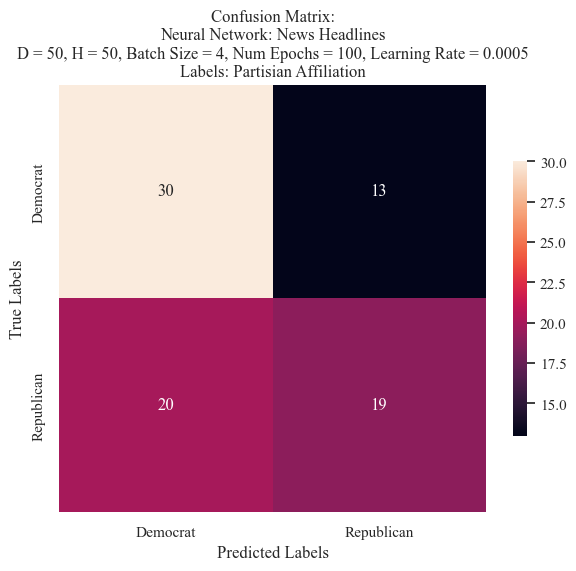

In [115]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 50, H = 50, Batch Size = 4, Num Epochs = 100, Learning Rate = 0.0005', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 5: d=500, h=500, batch_size = 8, num_epochs = 100, learning_rate = 0.0005, n_classes =1 

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs: 100%|████████████████████████████████| 100/100 [02:19<00:00,  1.39s/epoch]


----------------------------------------
Final training loss: 0.5475
The average epoch training loss is:
Avg train loss: 0.6775084581971167


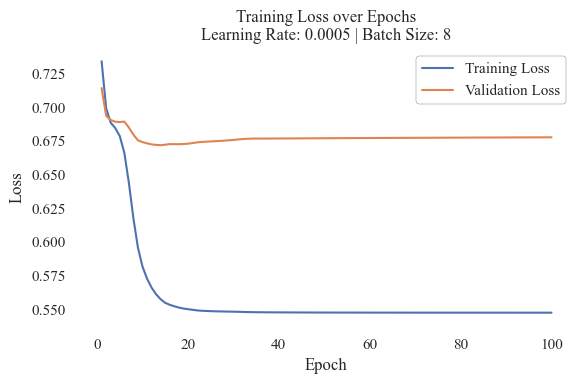

In [107]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=500, h=500, batch_size = 8, num_epochs = 100, learning_rate = 0.0005, n_classes =1 )

In [108]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.5609756097560976
precision: 0.5555555555555556
recall: 0.38461538461538464
f1: 0.45454545454545453


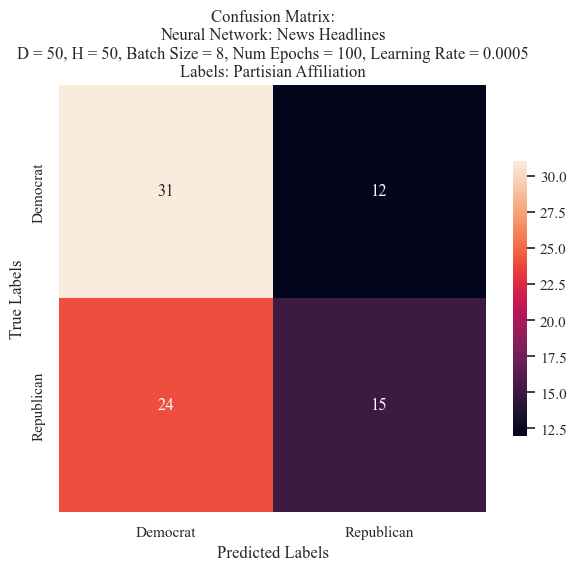

In [109]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 50, H = 50, Batch Size = 8, Num Epochs = 100, Learning Rate = 0.0005', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 6: d=700, h=700, batch_size = 4, num_epochs = 100, learning_rate = 0.0001, n_classes =1 )

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 700, padding_idx=0)
  (linear1): Linear(in_features=700, out_features=700, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=700, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs:  57%|██████████████████▊              | 57/100 [01:51<01:23,  1.95s/epoch]


----------------------------------------
Final training loss: 0.5534
The average epoch training loss is:
Avg train loss: 0.6811049856331156


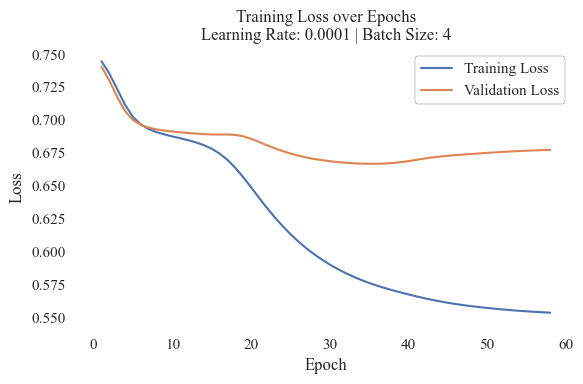

In [116]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=700, h=700, batch_size = 4, num_epochs = 100, learning_rate = 0.0001, n_classes =1 )

In [117]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.5853658536585366
precision: 0.5925925925925926
recall: 0.41025641025641024
f1: 0.48484848484848486


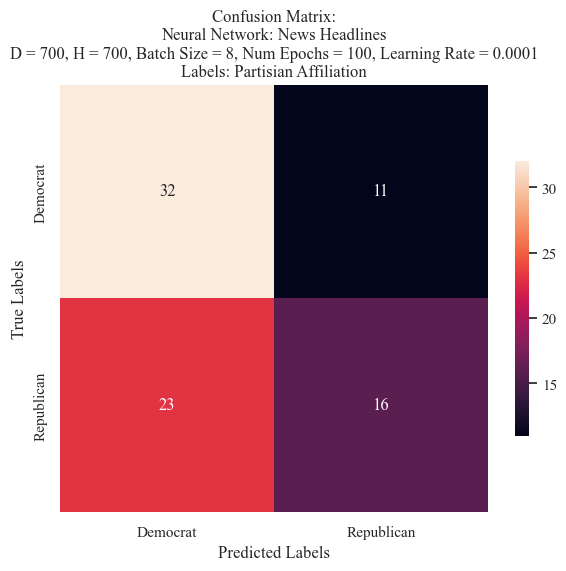

In [118]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 700, H = 700, Batch Size = 8, Num Epochs = 100, Learning Rate = 0.0001', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 7: d=500, h=500, batch_size = 8, num_epochs = 500, learning_rate = 0.0001, n_classes =1 

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs:   8%|██▊                              | 42/500 [00:42<07:43,  1.01s/epoch]


----------------------------------------
Final training loss: 0.5781
The average epoch training loss is:
Avg train loss: 0.6976899895095086


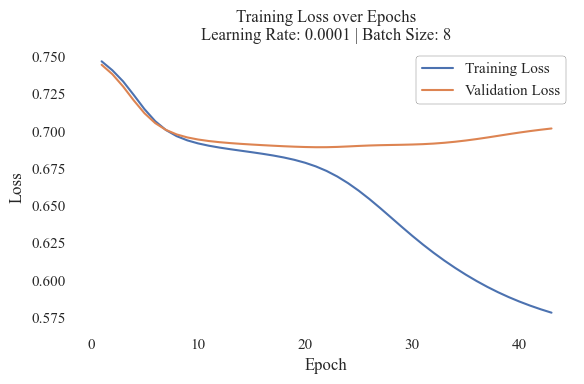

In [36]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=500, h=500, batch_size = 8, num_epochs = 500, learning_rate = 0.0001, n_classes =1 )

In [120]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.6707317073170732
precision: 0.75
recall: 0.46153846153846156
f1: 0.5714285714285714


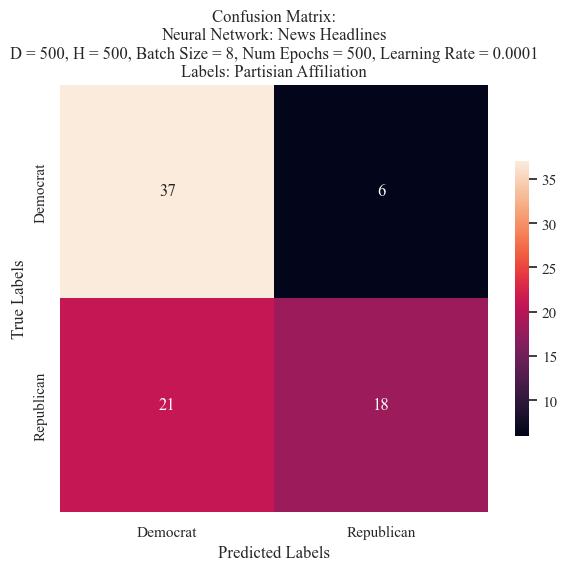

In [122]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 8, Num Epochs = 500, Learning Rate = 0.0001', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 8: d=500, h=500, batch_size = 4, num_epochs = 500, learning_rate = 0.00001, n_classes =1

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs: 100%|████████████████████████████████| 500/500 [11:35<00:00,  1.39s/epoch]


----------------------------------------
Final training loss: 0.5779
The average epoch training loss is:
Avg train loss: 0.6979008299311


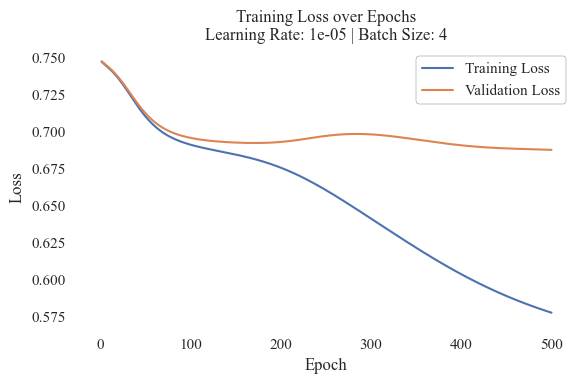

In [123]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=500, h=500, batch_size = 4, num_epochs = 500, learning_rate = 0.00001, n_classes =1 )

In [124]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.6219512195121951
precision: 0.7
recall: 0.358974358974359
f1: 0.4745762711864407


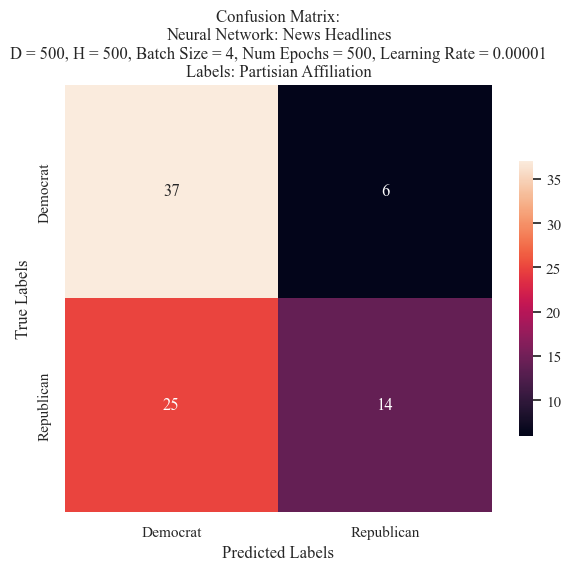

In [125]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 4, Num Epochs = 500, Learning Rate = 0.00001', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 9: d=500, h=500, batch_size = 4, num_epochs = 1000, learning_rate = 0.00001,

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs:  59%|██████████████████▏            | 586/1000 [09:22<06:37,  1.04epoch/s]


----------------------------------------
Final training loss: 0.5678
The average epoch training loss is:
Avg train loss: 0.7015345563846589


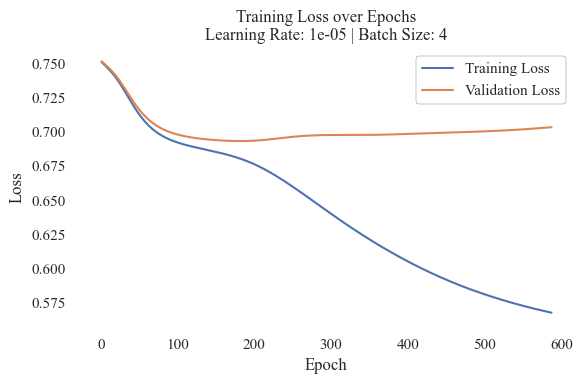

In [126]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=500, h=500, batch_size = 4, num_epochs = 1000, learning_rate = 0.00001, n_classes =1 )

In [127]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.6219512195121951
precision: 0.6666666666666666
recall: 0.41025641025641024
f1: 0.5079365079365079


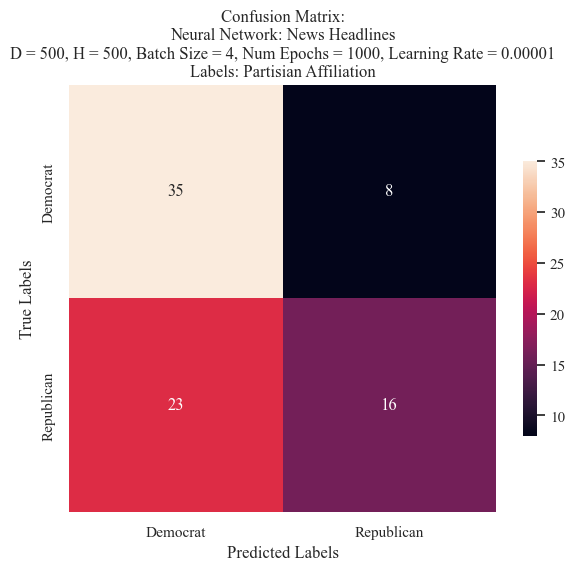

In [128]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 4, Num Epochs = 1000, Learning Rate = 0.00001', 'Partisian Affiliation', 'nn - news.png', 6,6)

#### TEST 10: d=500, h=500, batch_size = 16, num_epochs = 1000, learning_rate = 0.00001, n_classes =1

📌 Model Parameters:
Net(
  (embedding): Embedding(7729, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


🐛... | model is inching through the epochs: 100%|██████████████████████████████| 1000/1000 [17:13<00:00,  1.03s/epoch]


----------------------------------------
Final training loss: 0.5494
The average epoch training loss is:
Avg train loss: 0.6906876842975622


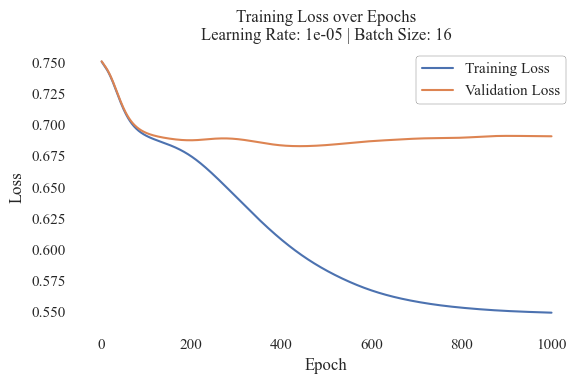

In [67]:
nn_news = training_loop(token2index_news, train_loader_news, val_loader_news, d=500, h=500, batch_size = 16, num_epochs = 1000, learning_rate = 0.00001, n_classes =1 )

In [131]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = evaluation(nn_news, test_loader_news)

accuracy: 0.5975609756097561
precision: 0.6
recall: 0.46153846153846156
f1: 0.5217391304347826


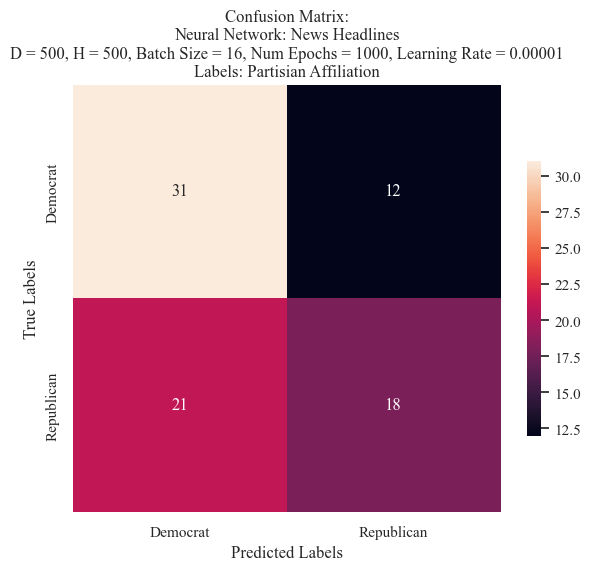

In [133]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 16, Num Epochs = 1000, Learning Rate = 0.00001', 'Partisian Affiliation', 'nn - news.png', 6,6)

### 3.2 Bills Data: Sponsor Affiliation

#### Model Instantiation

In [79]:
class Net(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_embeddings: int, embedding_dim: int, 
                 padding_idx: int = 0, pretrained_embeddings: torch.Tensor = None, freeze_embeddings: bool = False):
        super(Net, self).__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=padding_idx, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=padding_idx)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.activation = torch.nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 3)
        # self.sigmoid = torch.nn.Sigmoid() The softmax is removed here so that it can appropriately calculate the differences later

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1) 
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        #x = self.sigmoid(x)
        # directly returning the logits
        return (x)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#### Training Loop

In [80]:
def training_loop(token2index, train_loader, val_loader, d=50, h=50, batch_size=16, num_epochs=5, learning_rate=0.2, n_classes=1):
    ''' INTIALIZING GRAPH STYLE '''
    sb.set_style("white")
    sb.set(font='Times New Roman', font_scale=1)
    fig, ax = plt.subplots(figsize=(6, 4)) 
    ax.set_facecolor('white')
    
    ''' INITIALIZE MODEL '''
    model = Net(
        input_size=d,
        output_size=n_classes,  # Set to 1 for binary classification
        hidden_size=h,
        num_embeddings=len(token2index),
        embedding_dim=d,
        padding_idx=0
    )

    print("📌 Model Parameters:")
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(3, 0.01)

    # Loss function setup
    criterion = nn.CrossEntropyLoss()

    # Initialize lists to store loss data for plotting
    training_losses = []
    validation_losses = []

    for epoch in tqdm(range(num_epochs), desc='🐛... | model is inching through the epochs', unit = 'epoch'):
        #print(f"\n\nMODEL TRAINING ------------------\nEPOCH: {epoch}")
        model.train(True)
        train_loss = 0

        for X, y in train_loader:
            X = X.long()
            y = y.long() ## This is accounting for the training
            y_hat = model(X)

            loss = criterion(y_hat, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        val_losses = []

        with torch.no_grad():
            for input_, target in val_loader:
                target = target.long()
                input_ = input_.long()
                predictions = model(input_)
                val_loss_batch = criterion(predictions, target)
                val_losses.append(val_loss_batch.item())

        val_loss = sum(val_losses) / len(val_losses)

        # Store losses for plotting
        training_losses.append(train_loss / len(train_loader))
        validation_losses.append(val_loss)

        '''print('Training loss: %.4f' % (train_loss / len(train_loader)))
        print('Validation loss: %.4f' % val_loss)'''

        if early_stopper.early_stop(val_loss):
            break

    print('----------------------------------------')
    print(f"Final training loss: {train_loss / len(train_loader):.4f}")
    print("The average epoch training loss is:")
    print('Avg train loss:', sum(validation_losses) / len(validation_losses))
    
    # Prepare data for plotting
    epoch_data = pd.DataFrame({
        'Epoch': list(range(1, len(training_losses) + 1)),
        'Training Loss': training_losses,
        'Validation Loss': validation_losses
    })

    # Plot the loss values
    sb.lineplot(data=epoch_data, x='Epoch', y='Training Loss', label='Training Loss')
    sb.lineplot(data=epoch_data, x='Epoch', y='Validation Loss', label='Validation Loss')

    plt.title(f"Training Loss over Epochs\nLearning Rate: {learning_rate} | Batch Size: {batch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    legend = plt.legend()
    legend.get_frame().set_linewidth(.2)  
    legend.get_frame().set_edgecolor('black')  
    legend.get_frame().set_facecolor('none')
    plt.tight_layout()
    plt.show()

    return model


#### Evaluation

In [81]:
def evaluation(model, test_loader):
    all_predictions = []
    all_targets = []
    
    model.eval() 
    with torch.no_grad():
        for batch in test_loader:
            test_inputs, test_targets = batch
            test_inputs = test_inputs.long()
            test_targets = test_targets.long()

            test_outputs = model(test_inputs)
            
           
            _, predictions = torch.max(test_outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())  
            all_targets.extend(test_targets.cpu().numpy()) 

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    
    print(f'accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1: {f1}')
    
    return all_predictions, all_targets, accuracy, precision, recall, f1

#### Confusion Matrix

In [82]:

def visual_confusion_matrix(labels, predictions ,title, label_name, file_name, fig_x, fig_y):
    sb.set_style("white")
    sb.set(font='Times New Roman', font_scale=1)
    fig, ax = plt.subplots(figsize=(fig_x, fig_y)) 
    ax.set_facecolor('white')


    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()

    unique_labels = sorted(set(labels) | set(predictions))

    
    text_labels = list(label_encoder.inverse_transform(unique_labels))
    
    matrix_ = confusion_matrix(labels, predictions, labels = unique_labels)
    
    confusion_df = pd.DataFrame(matrix_, index=unique_labels, columns=unique_labels)
        
    
    sb.heatmap(confusion_df, annot = True, fmt='d', xticklabels=text_labels, yticklabels=text_labels, cbar_kws={'shrink': 0.5}, ax=ax)
    ax.set_title(f"Confusion Matrix:\n{title}\nLabels: {label_name}")
    ax.set_ylabel("True Labels")
    ax.set_xlabel("Predicted Labels")
    
    ax.set_aspect('equal', adjustable='box')
    #plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    
    # Save and show the plot
    
    plt.tight_layout(pad=.5)
    plt.savefig(file_name, dpi=600)
    
    plt.show()

#### TEST 1: d=50, h=50, batch_size = 16, num_epochs = 5, learning_rate = 0.2, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 50, padding_idx=0)
  (linear1): Linear(in_features=50, out_features=50, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=50, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:  60%|█████████████████████▌              | 3/5 [00:03<00:02,  1.24s/epoch]


----------------------------------------
Final training loss: 0.7530
The average epoch training loss is:
Avg train loss: 0.7401755487635021


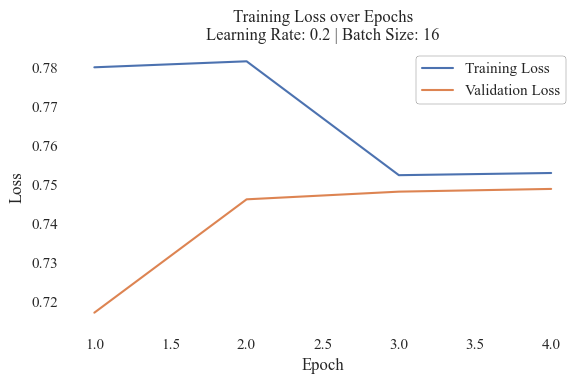

In [85]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=50, h=50, batch_size = 16, num_epochs = 5, learning_rate = 0.2, n_classes = 3 )

In [86]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.588957055214724
precision: 0.294478527607362
recall: 0.5
f1: 0.37065637065637064


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['D', 'R']
[[192   0]
 [134   0]]


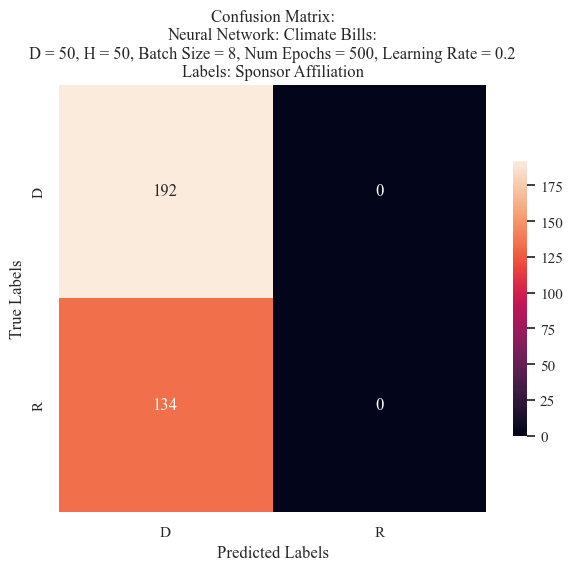

In [108]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 50, H = 50, Batch Size = 8, Num Epochs = 500, Learning Rate = 0.2', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 2: d=500, h=500, batch_size = 16, num_epochs = 500, learning_rate = 0.002, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   1%|▎                                 | 4/500 [00:26<54:40,  6.61s/epoch]


----------------------------------------
Final training loss: 0.1756
The average epoch training loss is:
Avg train loss: 0.5612823555157298


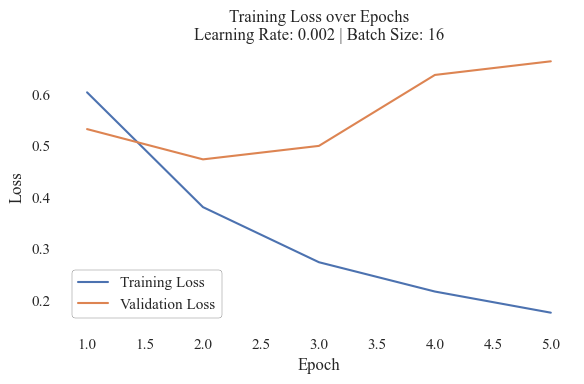

In [112]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=500, h=500, batch_size = 16, num_epochs = 500, learning_rate = 0.002, n_classes = 3 )

In [113]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8067484662576687
precision: 0.5356413879729942
recall: 0.533245232172471
f1: 0.5344269765322397


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


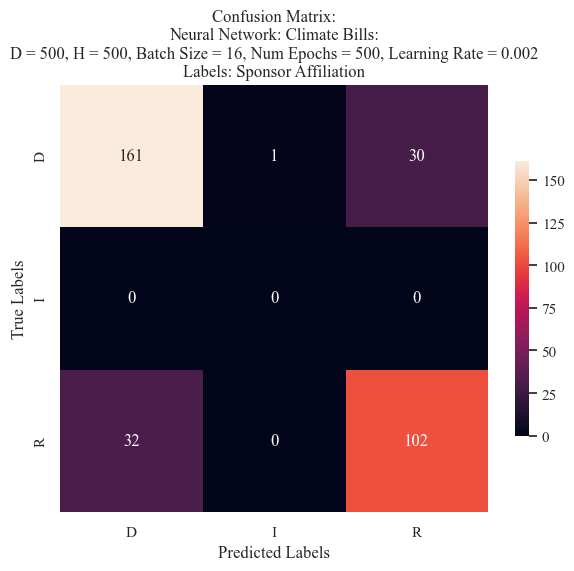

In [116]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 500, H = 500, Batch Size = 16, Num Epochs = 500, Learning Rate = 0.002', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 3:  d=500, h=500, batch_size = 8, num_epochs = 500, learning_rate = 0.002, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   1%|▎                                 | 4/500 [00:26<55:14,  6.68s/epoch]


----------------------------------------
Final training loss: 0.1710
The average epoch training loss is:
Avg train loss: 0.5484648803869884


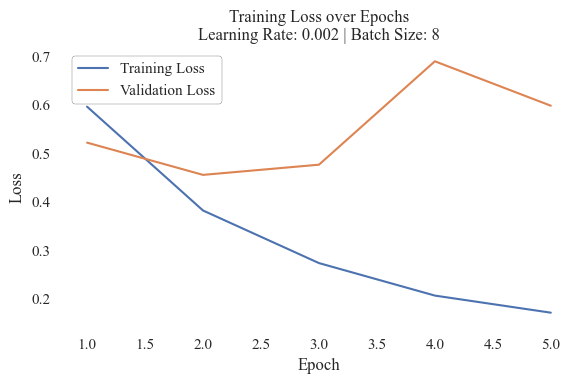

In [117]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=500, h=500, batch_size = 8, num_epochs = 500, learning_rate = 0.002, n_classes = 3 )

In [118]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8159509202453987
precision: 0.81255988502076
recall: 0.8042988184079602
f1: 0.8075787982528627


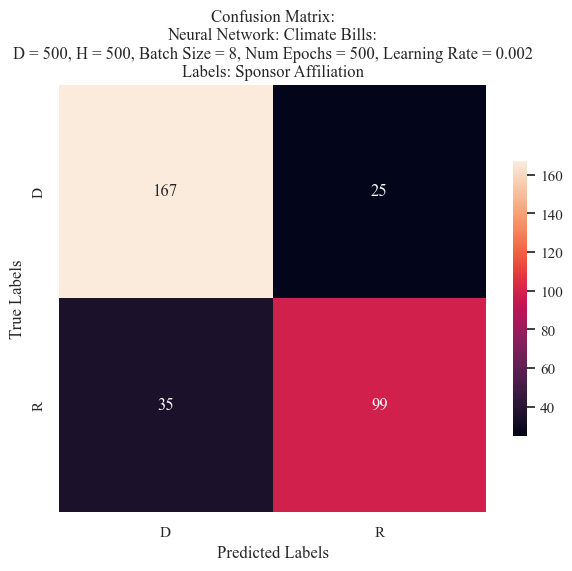

In [119]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 500, H = 500, Batch Size = 8, Num Epochs = 500, Learning Rate = 0.002', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 4: d=500, h=500, batch_size = 16, num_epochs = 500, learning_rate = 0.0009, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   1%|▍                                 | 6/500 [00:37<51:01,  6.20s/epoch]


----------------------------------------
Final training loss: 0.1524
The average epoch training loss is:
Avg train loss: 0.5072403338287963


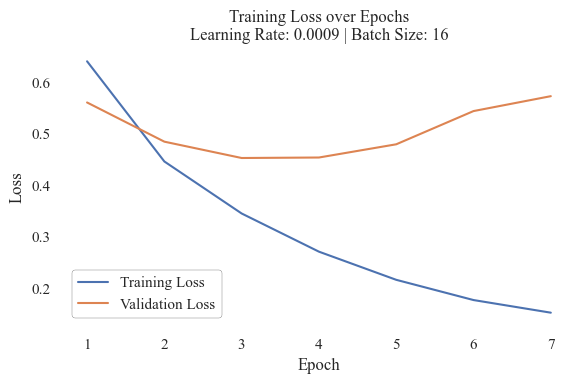

In [121]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=500, h=500, batch_size = 16, num_epochs = 500, learning_rate = 0.0009, n_classes = 3 )

In [122]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8251533742331288
precision: 0.8205446031558651
recall: 0.8166200248756219
f1: 0.8183701994975906


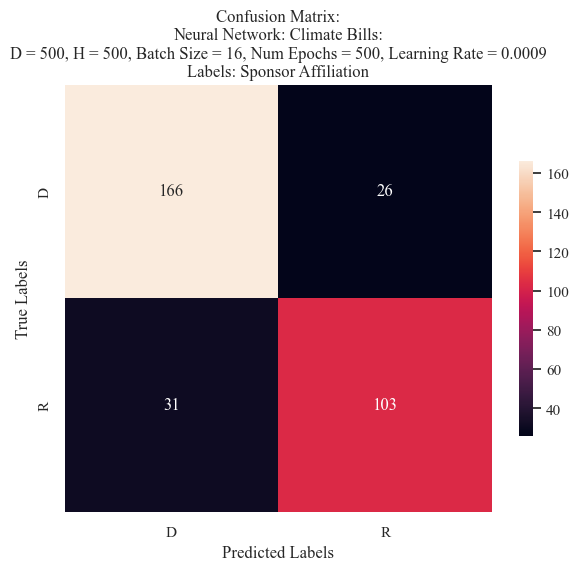

In [123]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 500, H = 500, Batch Size = 16, Num Epochs = 500, Learning Rate = 0.0009', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 5: d=250, h=250, batch_size = 16, num_epochs = 500, learning_rate = 0.002, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 250, padding_idx=0)
  (linear1): Linear(in_features=250, out_features=250, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=250, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   1%|▎                                 | 5/500 [00:17<29:29,  3.57s/epoch]


----------------------------------------
Final training loss: 0.1517
The average epoch training loss is:
Avg train loss: 0.48324873623630354


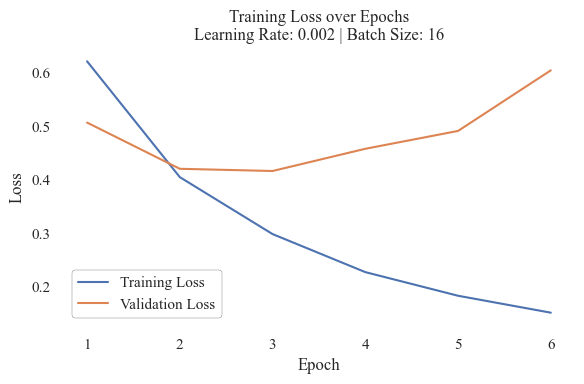

In [124]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=250, h=250, batch_size = 16, num_epochs = 500, learning_rate = 0.002, n_classes = 3 )

In [125]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8251533742331288
precision: 0.8190823774765381
recall: 0.8211287313432836
f1: 0.8200307987331842


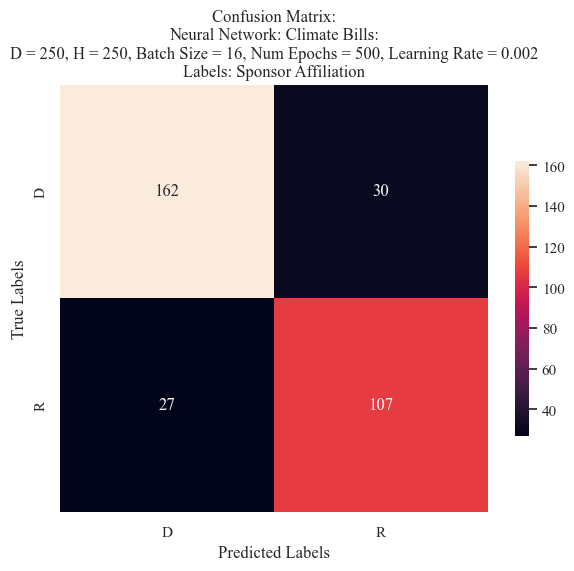

In [126]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 250, H = 250, Batch Size = 16, Num Epochs = 500, Learning Rate = 0.002', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 6: d=500, h=500, batch_size = 32, num_epochs = 500, learning_rate = 0.0001, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   6%|█▉                               | 29/500 [02:54<47:11,  6.01s/epoch]


----------------------------------------
Final training loss: 0.1715
The average epoch training loss is:
Avg train loss: 0.4919410971895096


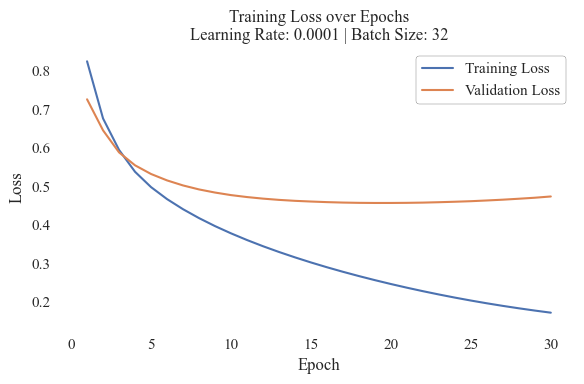

In [128]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=500, h=500, batch_size = 32, num_epochs = 500, learning_rate = 0.0001, n_classes = 3 )

In [129]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8098159509202454
precision: 0.5395100485658322
recall: 0.5319755389718076
f1: 0.5350951694351722


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


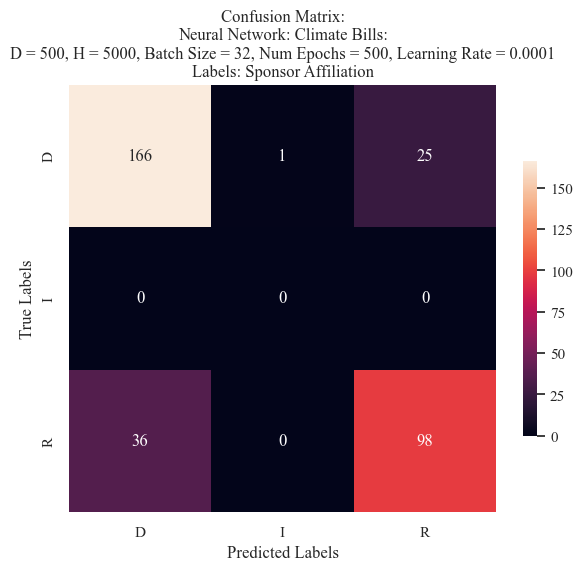

In [130]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 500, H = 5000, Batch Size = 32, Num Epochs = 500, Learning Rate = 0.0001', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 7: d=250, h=250, batch_size = 16, num_epochs = 500, learning_rate = 0.001, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 250, padding_idx=0)
  (linear1): Linear(in_features=250, out_features=250, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=250, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   1%|▍                                 | 6/500 [00:20<28:32,  3.47s/epoch]


----------------------------------------
Final training loss: 0.1694
The average epoch training loss is:
Avg train loss: 0.4990110987303208


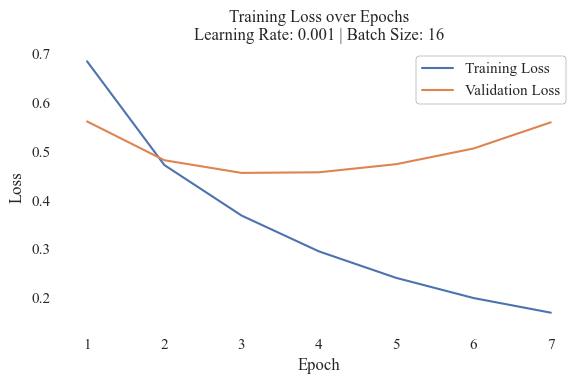

In [132]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=250, h=250, batch_size = 16, num_epochs = 500, learning_rate = 0.001, n_classes = 3 )

In [133]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8098159509202454
precision: 0.8038894095595126
recall: 0.8024720149253731
f1: 0.8031477657875258


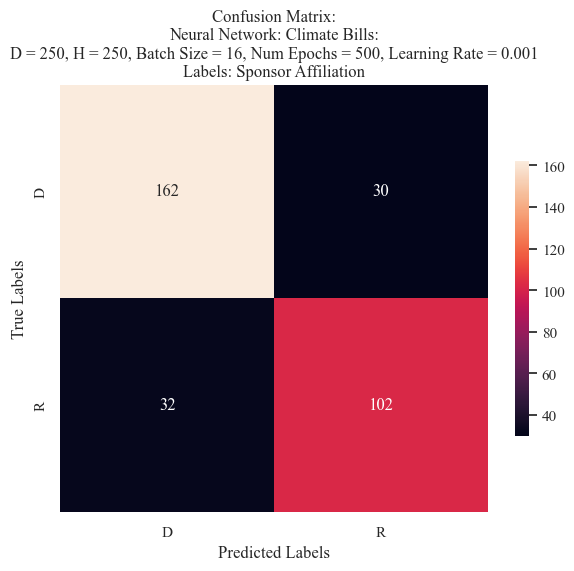

In [134]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 250, H = 250, Batch Size = 16, Num Epochs = 500, Learning Rate = 0.001', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 8: d=300, h=300, batch_size = 16, num_epochs = 500, learning_rate = 0.002, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 300, padding_idx=0)
  (linear1): Linear(in_features=300, out_features=300, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=300, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   1%|▎                                 | 4/500 [00:17<35:23,  4.28s/epoch]


----------------------------------------
Final training loss: 0.1822
The average epoch training loss is:
Avg train loss: 0.4949140899947711


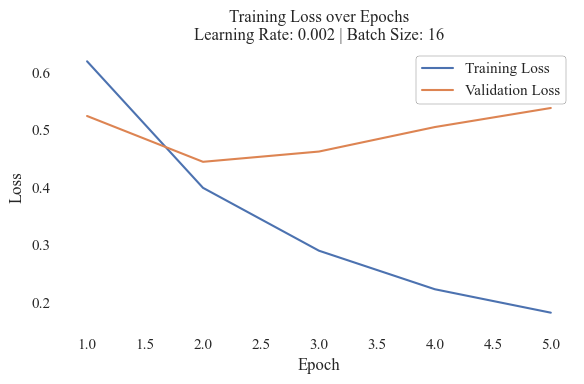

In [135]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=300, h=300, batch_size = 16, num_epochs = 500, learning_rate = 0.002, n_classes = 3 )

In [136]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8190184049079755
precision: 0.8193473193473193
recall: 0.8035214552238805
f1: 0.8089040347338824


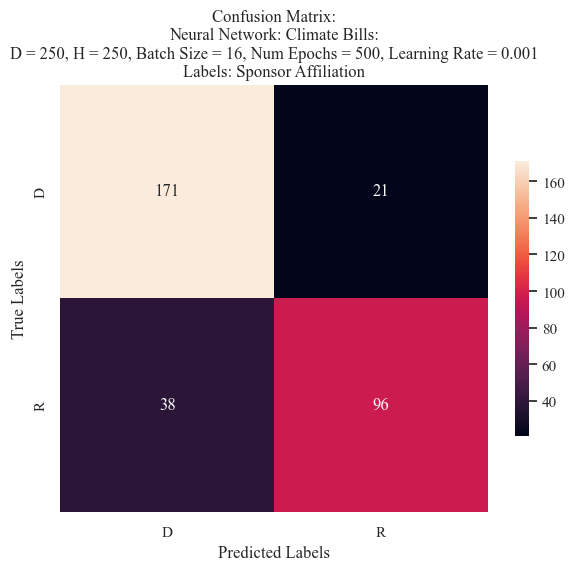

In [137]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 250, H = 250, Batch Size = 16, Num Epochs = 500, Learning Rate = 0.001', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 9: d=500, h=500, batch_size = 16, num_epochs = 500, learning_rate = 0.0001, n_classes = 3 

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   5%|█▌                               | 24/500 [02:14<44:30,  5.61s/epoch]


----------------------------------------
Final training loss: 0.1954
The average epoch training loss is:
Avg train loss: 0.49163942694664015


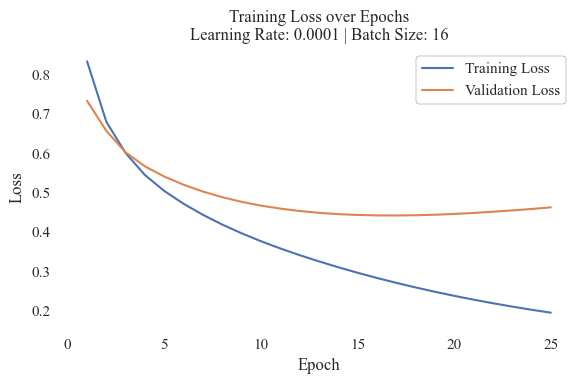

In [138]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=500, h=500, batch_size = 16, num_epochs = 500, learning_rate = 0.0001, n_classes = 3 )

In [139]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.7975460122699386
precision: 0.7924206349206349
recall: 0.7864194651741294
f1: 0.7888932496075354


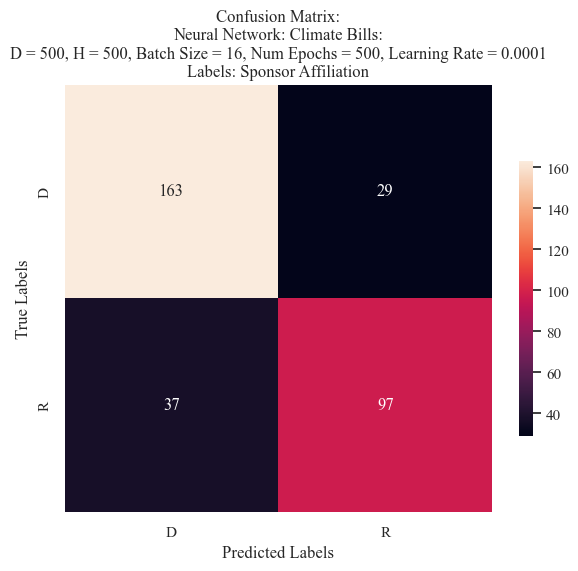

In [140]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 500, H = 500, Batch Size = 16, Num Epochs = 500, Learning Rate = 0.0001', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

#### TEST 10: d=499, h=499, batch_size = 31, num_epochs = 500, learning_rate = 0.00015, n_classes = 3

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 499, padding_idx=0)
  (linear1): Linear(in_features=499, out_features=499, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=499, out_features=3, bias=True)
)


🐛... | model is inching through the epochs:   3%|▉                                | 15/500 [01:35<51:15,  6.34s/epoch]


----------------------------------------
Final training loss: 0.2125
The average epoch training loss is:
Avg train loss: 0.5460310747758264


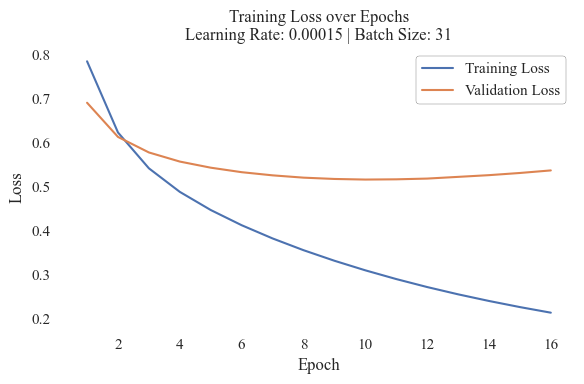

In [83]:
nn_bills_party = training_loop(token2index_bills, train_loader_bills_party, val_loader_bills_party, d=499, h=499, batch_size = 31, num_epochs = 500, learning_rate = 0.00015, n_classes = 3 )

In [142]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = evaluation(nn_bills_party, test_loader_bills_party)

accuracy: 0.8159509202453987
precision: 0.8106750392464679
recall: 0.8076803482587065
f1: 0.8090440487347703


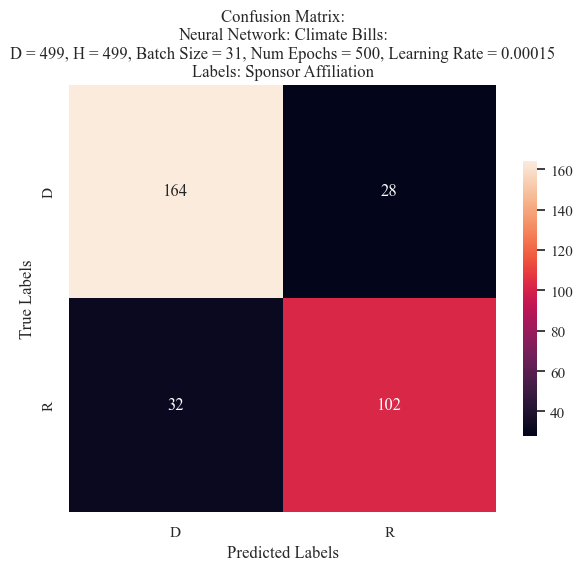

In [143]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nD = 499, H = 499, Batch Size = 31, Num Epochs = 500, Learning Rate = 0.00015', 'Sponsor Affiliation', 'nn - bills - party.png', 6,6)

### 3.2 Bills Data: Sponsor State

In [150]:
''' FINDING THE NUMBER OF LABELS: '''
print (len(list(set(list(bills_data_raw['Sponser State'])))))
state_label_length = (len(list(set(list(bills_data_raw['Sponser State'])))))

54


#### Model Instantiation

In [151]:
class Net(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_embeddings: int, embedding_dim: int, 
                 padding_idx: int = 0, pretrained_embeddings: torch.Tensor = None, freeze_embeddings: bool = False):
        super(Net, self).__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=padding_idx, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=padding_idx)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.activation = torch.nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, state_label_length)
        # self.sigmoid = torch.nn.Sigmoid() The softmax is removed here so that it can appropriately calculate the differences later

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1) 
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        #x = self.sigmoid(x)
        # directly returning the logits
        return (x)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#### Training Loop

In [152]:
def training_loop(token2index, train_loader, val_loader, d=50, h=50, batch_size=16, num_epochs=5, learning_rate=0.2, n_classes=state_label_length):
    ''' INTIALIZING GRAPH STYLE '''
    sb.set_style("white")
    sb.set(font='Times New Roman', font_scale=1)
    fig, ax = plt.subplots(figsize=(6, 4)) 
    ax.set_facecolor('white')
    
    ''' INITIALIZE MODEL '''
    model = Net(
        input_size=d,
        output_size=n_classes,  # Set to 1 for binary classification
        hidden_size=h,
        num_embeddings=len(token2index),
        embedding_dim=d,
        padding_idx=0
    )

    print("📌 Model Parameters:")
    print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(3, 0.01)

    # Loss function setup
    criterion = nn.CrossEntropyLoss()

    # Initialize lists to store loss data for plotting
    training_losses = []
    validation_losses = []

    for epoch in tqdm(range(num_epochs), desc='🐛... | model is inching through the epochs', unit = 'epoch'):
        #print(f"\n\nMODEL TRAINING ------------------\nEPOCH: {epoch}")
        model.train(True)
        train_loss = 0

        for X, y in train_loader:
            X = X.long()
            y = y.long() ## This is accounting for the training
            y_hat = model(X)

            loss = criterion(y_hat, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        val_losses = []

        with torch.no_grad():
            for input_, target in val_loader:
                target = target.long()
                input_ = input_.long()
                predictions = model(input_)
                val_loss_batch = criterion(predictions, target)
                val_losses.append(val_loss_batch.item())

        val_loss = sum(val_losses) / len(val_losses)

        # Store losses for plotting
        training_losses.append(train_loss / len(train_loader))
        validation_losses.append(val_loss)

        '''print('Training loss: %.4f' % (train_loss / len(train_loader)))
        print('Validation loss: %.4f' % val_loss)'''

        if early_stopper.early_stop(val_loss):
            break

    print('----------------------------------------')
    print(f"Final training loss: {train_loss / len(train_loader):.4f}")
    print("The average epoch training loss is:")
    print('Avg train loss:', sum(validation_losses) / len(validation_losses))
    
    # Prepare data for plotting
    epoch_data = pd.DataFrame({
        'Epoch': list(range(1, len(training_losses) + 1)),
        'Training Loss': training_losses,
        'Validation Loss': validation_losses
    })

    # Plot the loss values
    sb.lineplot(data=epoch_data, x='Epoch', y='Training Loss', label='Training Loss')
    sb.lineplot(data=epoch_data, x='Epoch', y='Validation Loss', label='Validation Loss')

    plt.title(f"Training Loss over Epochs\nLearning Rate: {learning_rate} | Batch Size: {batch_size}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    legend = plt.legend()
    legend.get_frame().set_linewidth(.2)  
    legend.get_frame().set_edgecolor('black')  
    legend.get_frame().set_facecolor('none')
    plt.tight_layout()
    plt.show()

    return model


#### Evaluation

In [153]:
def evaluation(model, test_loader):
    all_predictions = []
    all_targets = []
    
    model.eval() 
    with torch.no_grad():
        for batch in test_loader:
            test_inputs, test_targets = batch
            test_inputs = test_inputs.long()
            test_targets = test_targets.long()

            test_outputs = model(test_inputs)
            
           
            _, predictions = torch.max(test_outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())  
            all_targets.extend(test_targets.cpu().numpy()) 

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    
    print(f'accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1: {f1}')
    
    return all_predictions, all_targets, accuracy, precision, recall, f1

#### TEST 1:  d=50, h=50, batch_size = 16, num_epochs = 5, learning_rate = 0.2, n_classes = state_label_length

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 50, padding_idx=0)
  (linear1): Linear(in_features=50, out_features=50, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=50, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:  80%|████████████████████████████▊       | 4/5 [00:05<00:01,  1.28s/epoch]


----------------------------------------
Final training loss: 3.6842
The average epoch training loss is:
Avg train loss: 3.7415439492180234


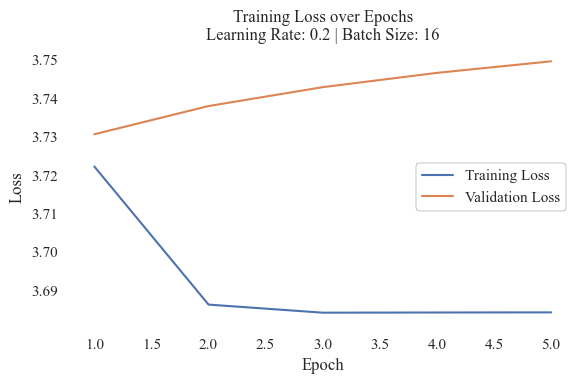

In [155]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=50, h=50, batch_size = 16, num_epochs = 5, learning_rate = 0.2, n_classes = state_label_length )

In [156]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.11349693251533742
precision: 0.0022254300493203417
recall: 0.0196078431372549
f1: 0.0039971911629665645


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


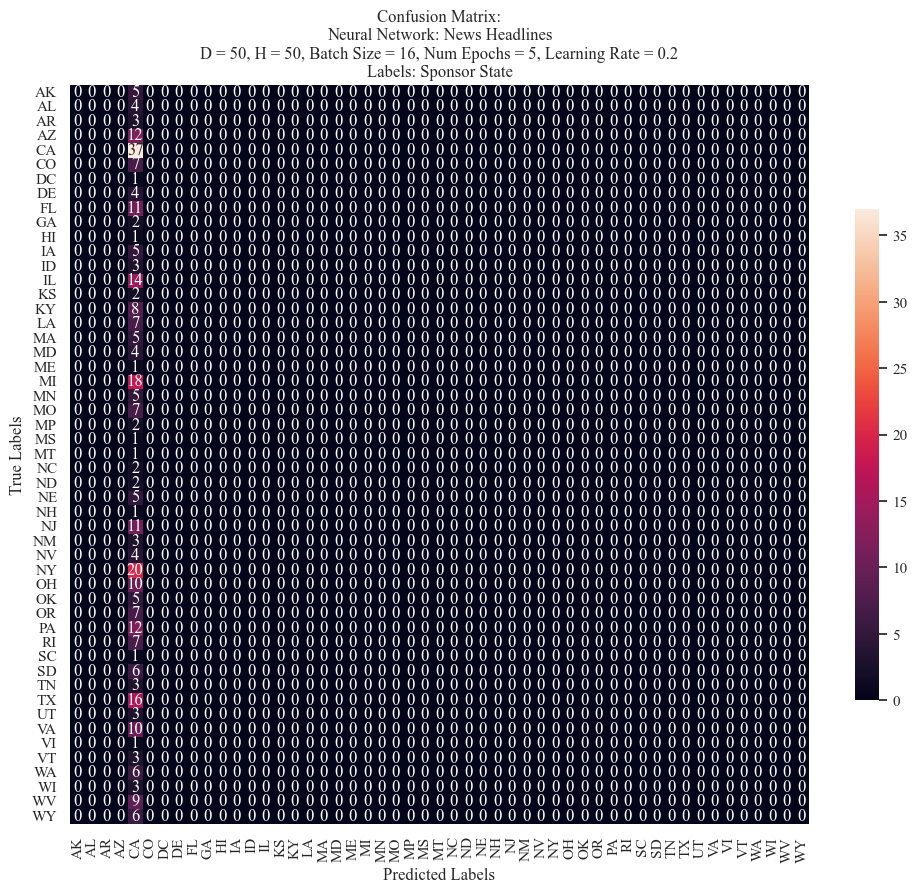

In [161]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 50, H = 50, Batch Size = 16, Num Epochs = 5, Learning Rate = 0.2', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 2: d=500, h=500, batch_size = 32, num_epochs = 500, learning_rate = 0.0001

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:  14%|████▍                            | 68/500 [06:39<42:17,  5.87s/epoch]


----------------------------------------
Final training loss: 0.9862
The average epoch training loss is:
Avg train loss: 3.0455467832590304


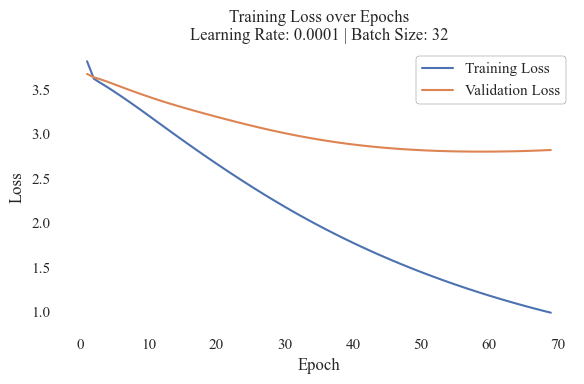

In [162]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=500, h=500, batch_size = 32, num_epochs = 500, learning_rate = 0.0001, n_classes = state_label_length )

In [163]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.04294478527607362
precision: 0.01933066933066933
recall: 0.015948990948990948
f1: 0.015324607572524747


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


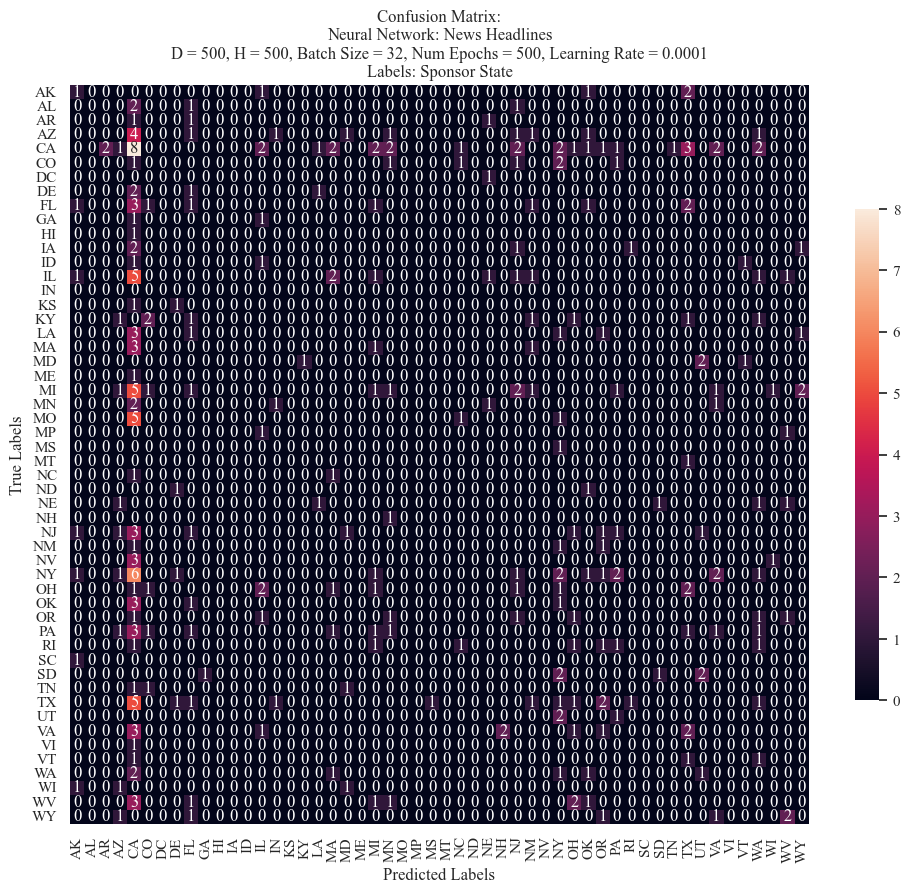

In [164]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 32, Num Epochs = 500, Learning Rate = 0.0001', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 3: d=750, h=750, batch_size = 16, num_epochs = 500, learning_rate = 0.005,

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 750, padding_idx=0)
  (linear1): Linear(in_features=750, out_features=750, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=750, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:   1%|▎                               | 4/500 [00:42<1:26:54, 10.51s/epoch]


----------------------------------------
Final training loss: 0.7179
The average epoch training loss is:
Avg train loss: 3.2331655502319334


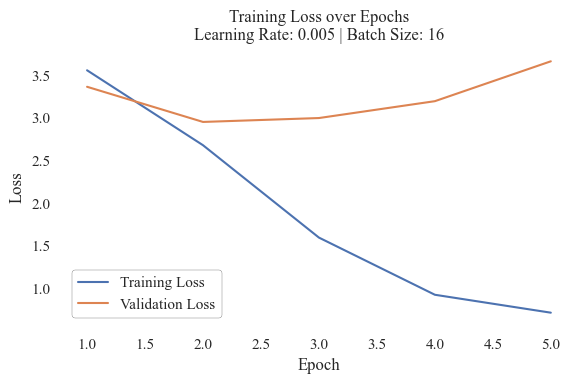

In [165]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=750, h=750, batch_size = 16, num_epochs = 500, learning_rate = 0.005, n_classes = state_label_length )

In [166]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.05521472392638037
precision: 0.017979010150828697
recall: 0.017767093238791352
f1: 0.016419756662769312


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


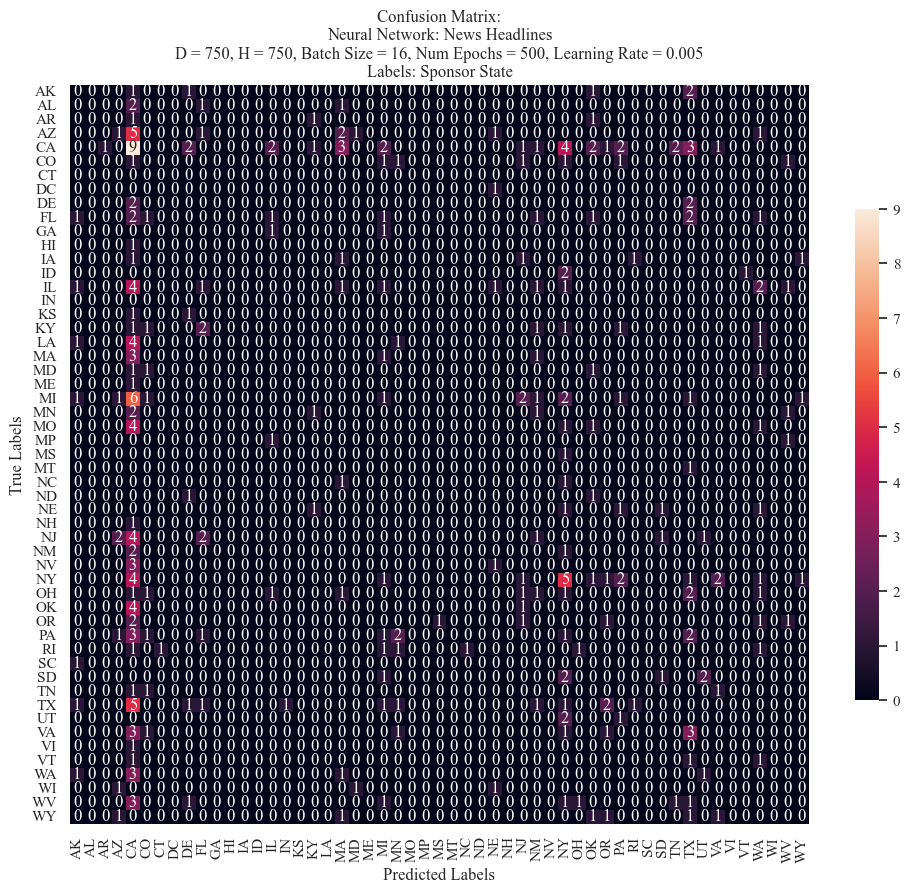

In [167]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 750, H = 750, Batch Size = 16, Num Epochs = 500, Learning Rate = 0.005', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 4: d=50, h=50, batch_size = 200, num_epochs = 500, learning_rate = 0.005

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 50, padding_idx=0)
  (linear1): Linear(in_features=50, out_features=50, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=50, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:   1%|▍                                 | 7/500 [00:06<07:39,  1.07epoch/s]


----------------------------------------
Final training loss: 0.8714
The average epoch training loss is:
Avg train loss: 3.2677717265628634


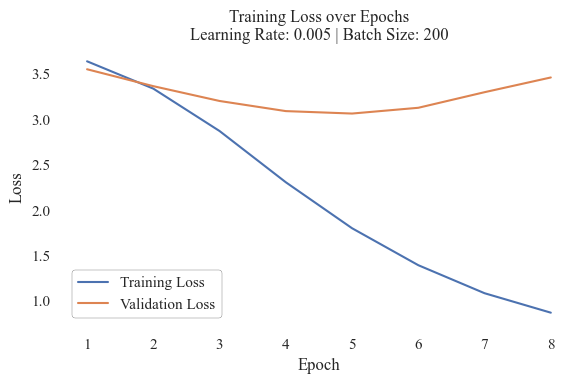

In [175]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=50, h=50, batch_size = 200, num_epochs = 500, learning_rate = 0.005, n_classes = state_label_length )

In [176]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.03987730061349693
precision: 0.021224116335963886
recall: 0.014571714571714571
f1: 0.015501500728005121


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


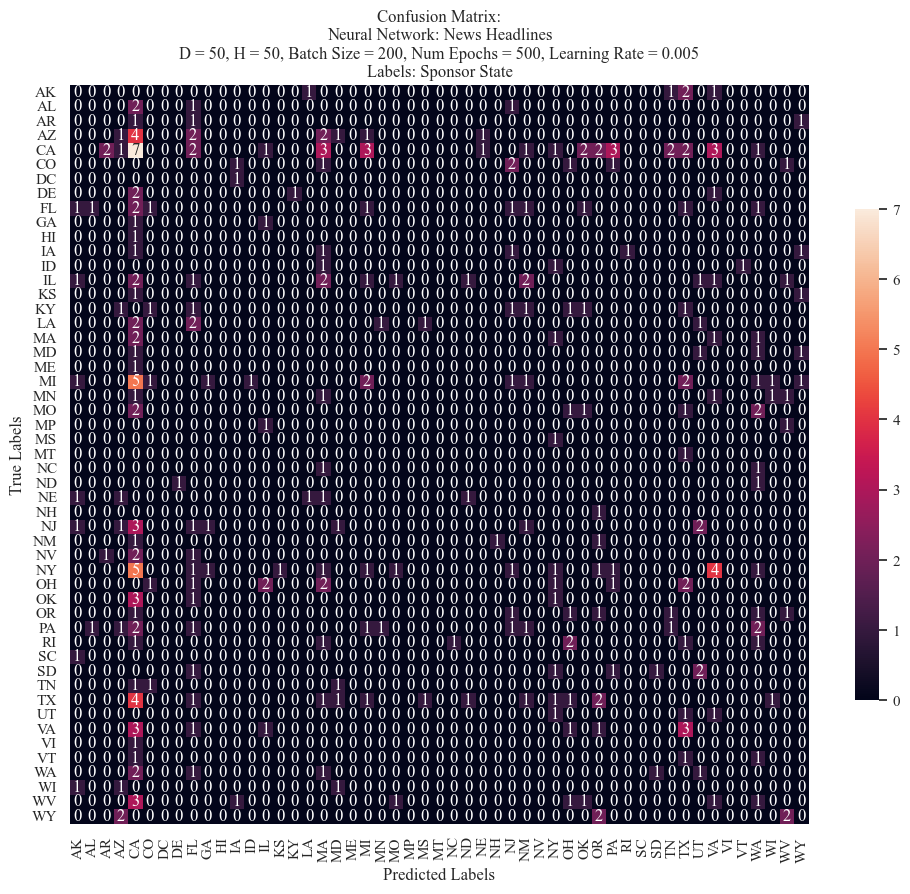

In [178]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 50, H = 50, Batch Size = 200, Num Epochs = 500, Learning Rate = 0.005', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 5: d=50, h=50, batch_size = 200, num_epochs = 500, learning_rate = 0.0005

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 50, padding_idx=0)
  (linear1): Linear(in_features=50, out_features=50, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=50, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:  80%|█████████████████████████▋      | 402/500 [05:26<01:19,  1.23epoch/s]


----------------------------------------
Final training loss: 1.9621
The average epoch training loss is:
Avg train loss: 3.4542957508125935


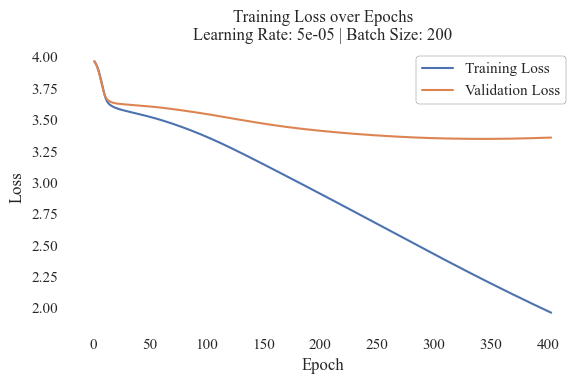

In [182]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=50, h=50, batch_size = 200, num_epochs = 500, learning_rate = 0.00005, n_classes = state_label_length )

In [180]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.0705521472392638
precision: 0.024261582288956765
recall: 0.029273046920105746
f1: 0.025484444499724635


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


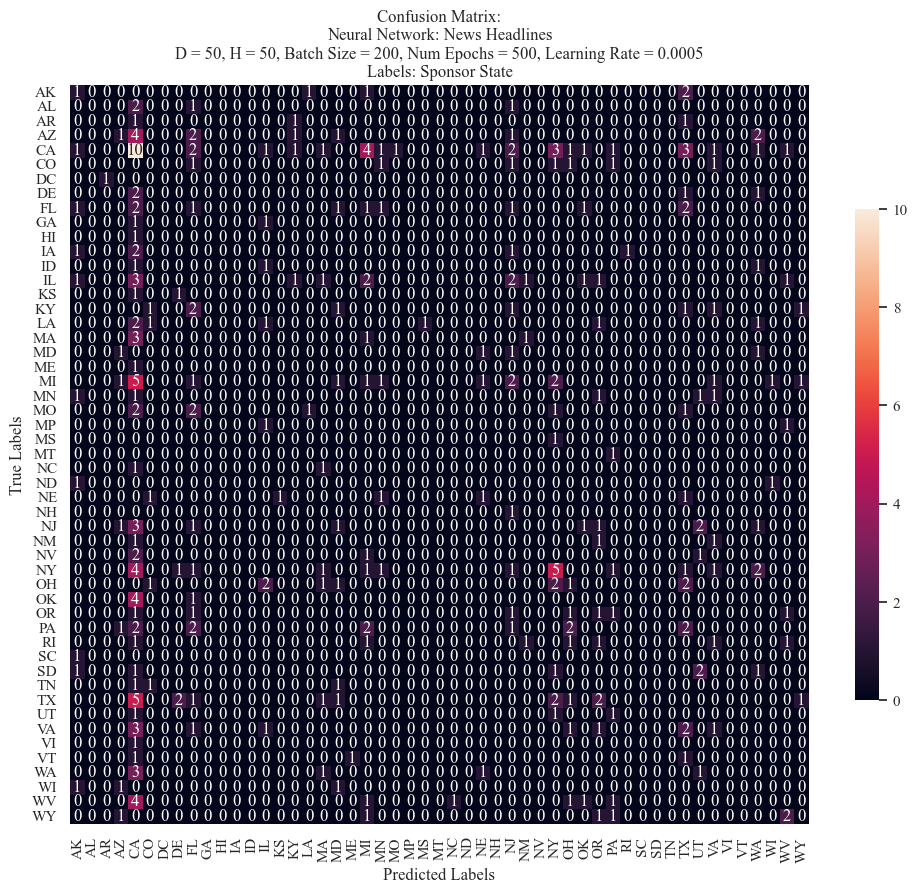

In [181]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 50, H = 50, Batch Size = 200, Num Epochs = 500, Learning Rate = 0.0005', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 6: d=100, h=100, batch_size = 250, num_epochs = 500, learning_rate = 0.00005,

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 100, padding_idx=0)
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=100, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:  66%|█████████████████████▏          | 331/500 [08:32<04:21,  1.55s/epoch]


----------------------------------------
Final training loss: 1.4773
The average epoch training loss is:
Avg train loss: 3.361992975247025


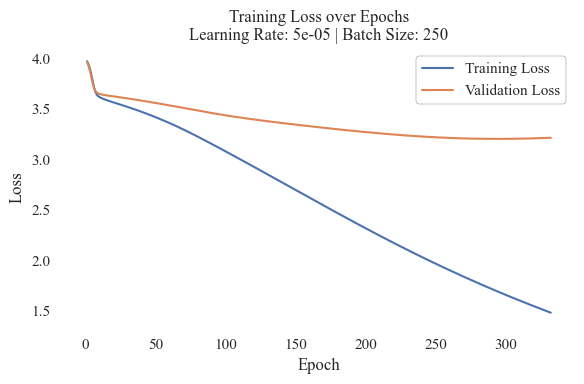

In [183]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=100, h=100, batch_size = 250, num_epochs = 500, learning_rate = 0.00005, n_classes = state_label_length )

In [184]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.05214723926380368
precision: 0.018520908104241438
recall: 0.020138551388551387
f1: 0.018206436738996953


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


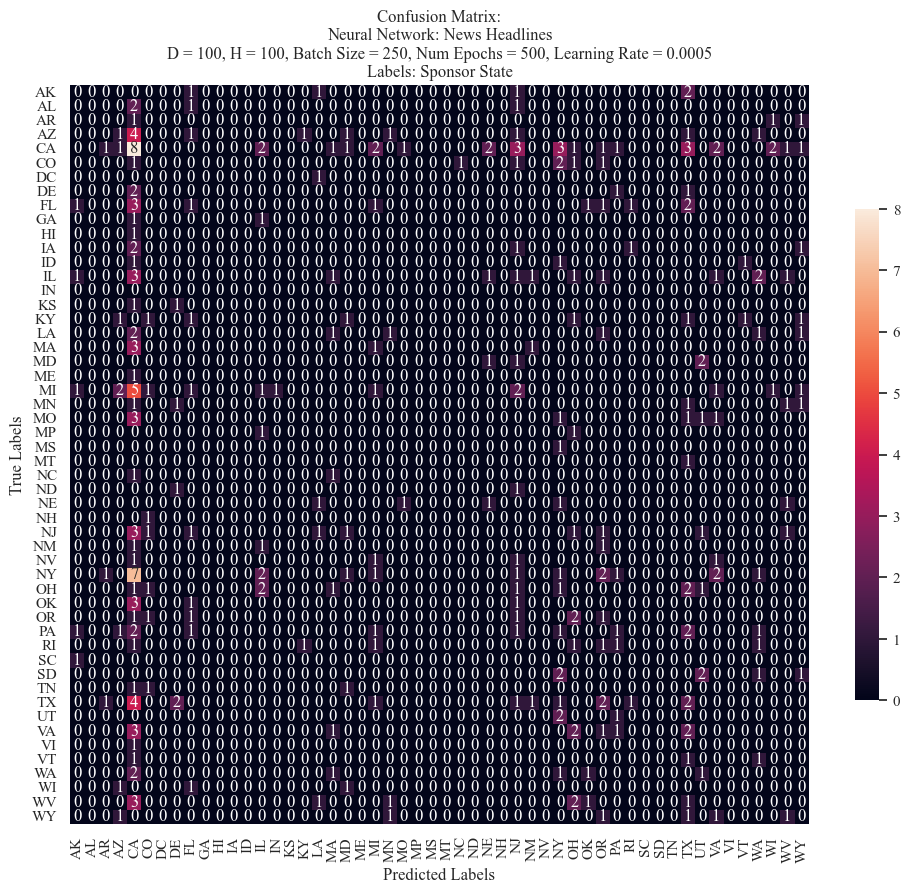

In [185]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 100, H = 100, Batch Size = 250, Num Epochs = 500, Learning Rate = 0.0005', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 7: d=250, h=250, batch_size = 250, num_epochs = 1500, learning_rate = 0.00005,

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 250, padding_idx=0)
  (linear1): Linear(in_features=250, out_features=250, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=250, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:   7%|█▉                            | 99/1500 [07:48<1:50:33,  4.73s/epoch]


----------------------------------------
Final training loss: 1.2158
The average epoch training loss is:
Avg train loss: 3.202417530786424


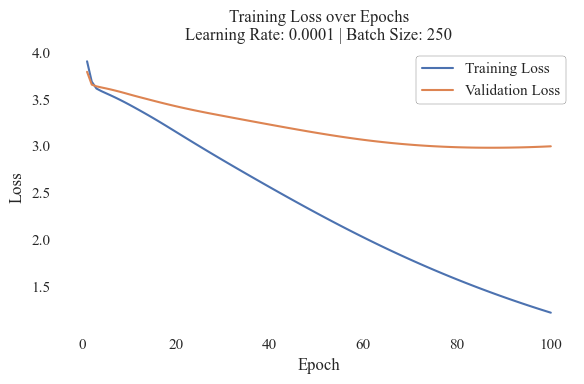

In [191]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=250, h=250, batch_size = 250, num_epochs = 1500, learning_rate = 0.0001, n_classes = state_label_length )

In [192]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.06441717791411043
precision: 0.027148846960167713
recall: 0.02310619857789669
f1: 0.022755265995497757


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


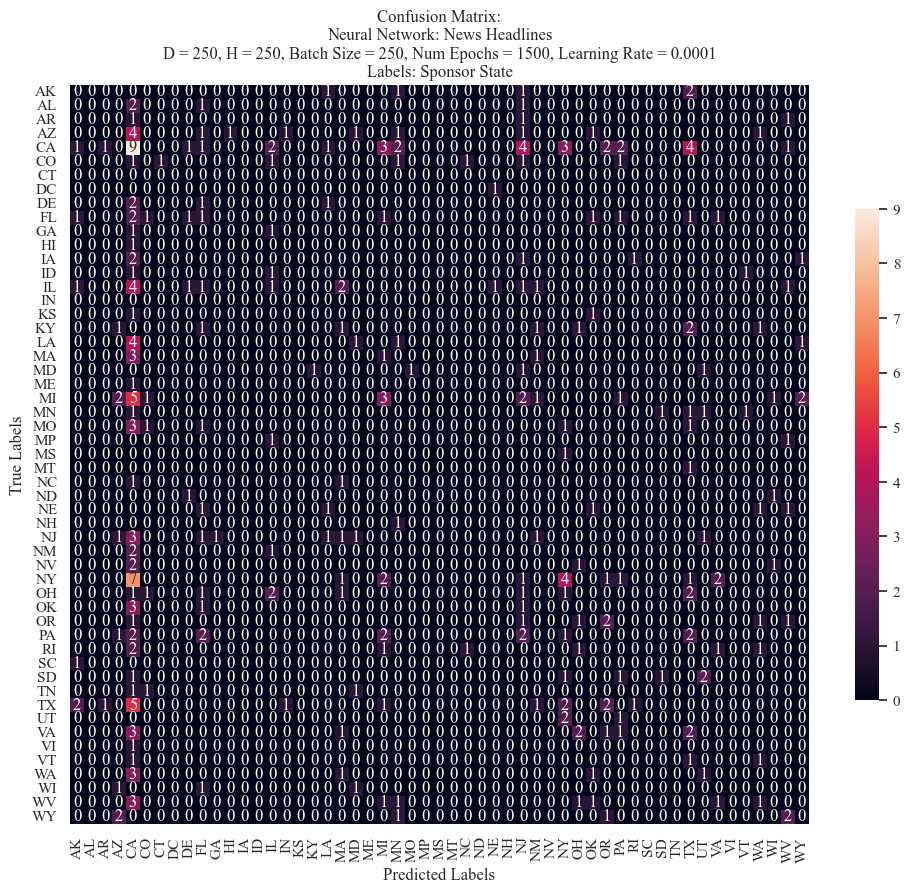

In [194]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 250, H = 250, Batch Size = 250, Num Epochs = 1500, Learning Rate = 0.0001', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 8: d=500, h=500, batch_size = 16, num_epochs = 1500, learning_rate = 0.0001

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:  43%|███████████▋               | 651/1500 [1:03:39<1:23:01,  5.87s/epoch]


----------------------------------------
Final training loss: 1.1560
The average epoch training loss is:
Avg train loss: 3.286523166418142


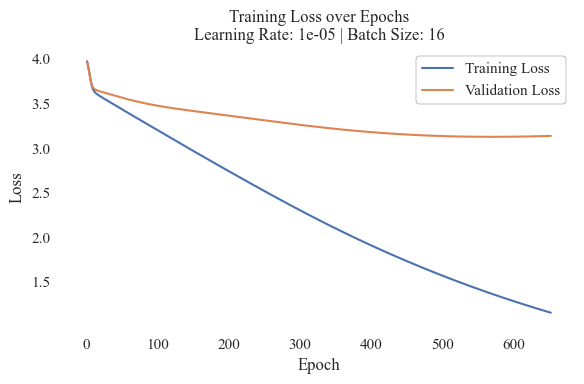

In [200]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=500, h=500, batch_size = 16, num_epochs = 1500, learning_rate = 0.00001, n_classes = state_label_length )

In [201]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.06134969325153374
precision: 0.02901935485547526
recall: 0.02545918795918796
f1: 0.024335125161524994


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


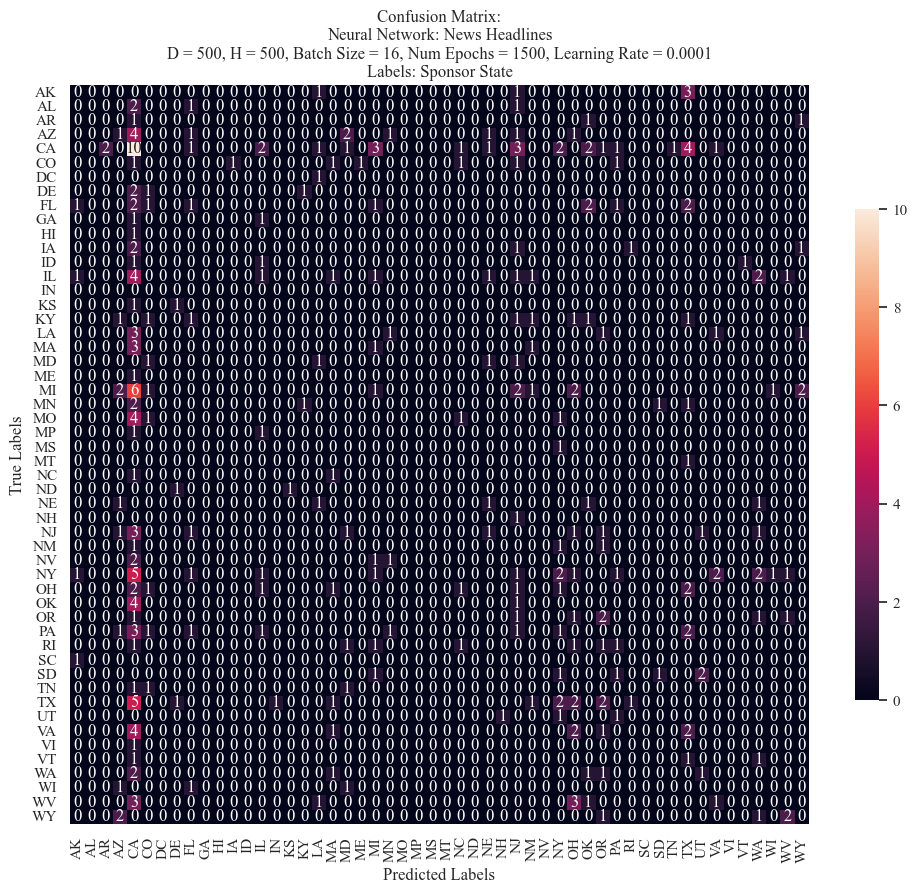

In [202]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 16, Num Epochs = 1500, Learning Rate = 0.0001', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 9: d=500, h=500, batch_size = 16, num_epochs = 1500, learning_rate = 0.001

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 500, padding_idx=0)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=500, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:   1%|▏                             | 10/1500 [00:59<2:27:11,  5.93s/epoch]


----------------------------------------
Final training loss: 0.6690
The average epoch training loss is:
Avg train loss: 2.9542476140059435


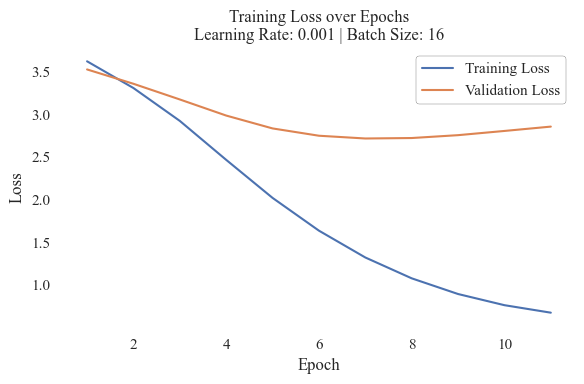

In [203]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=500, h=500, batch_size = 16, num_epochs = 1500, learning_rate = 0.001, n_classes = state_label_length )

In [204]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.05214723926380368
precision: 0.01921093414008394
recall: 0.017933942933942935
f1: 0.017101857497078085


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


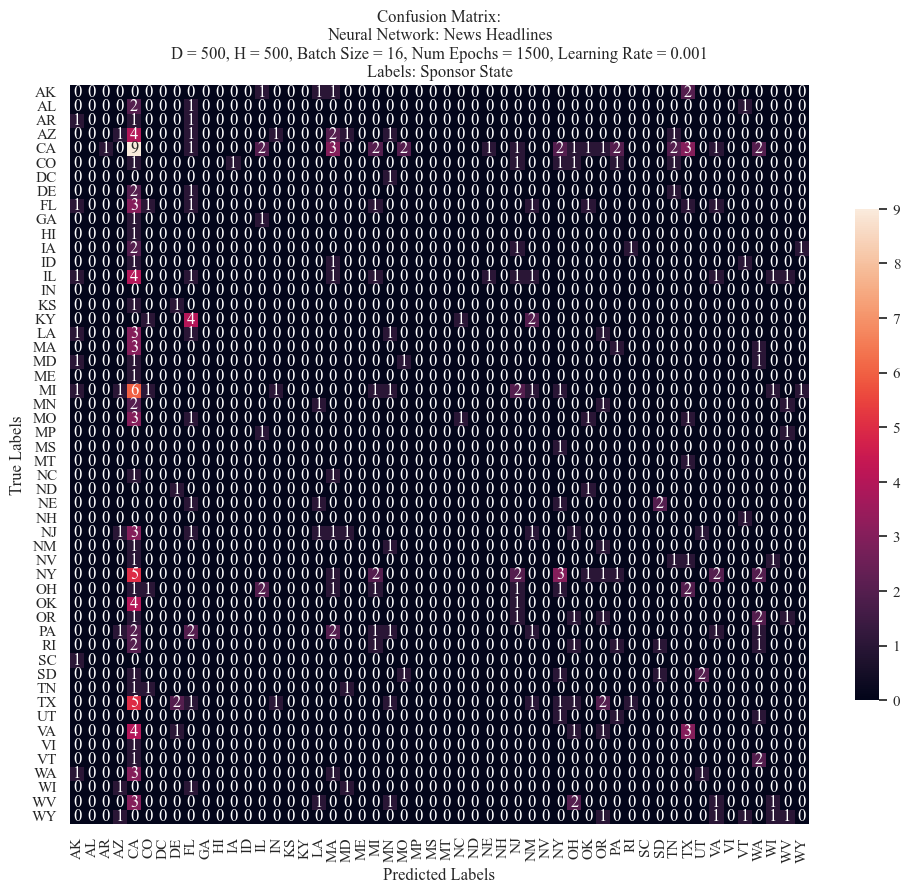

In [205]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 500, H = 500, Batch Size = 16, Num Epochs = 1500, Learning Rate = 0.001', 'Sponsor State', 'nn - bills - state.png', 10,10)

#### TEST 10: d=700, h=700, batch_size = 8, num_epochs = 1500, learning_rate = 0.01

📌 Model Parameters:
Net(
  (embedding): Embedding(12268, 700, padding_idx=0)
  (linear1): Linear(in_features=700, out_features=700, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=700, out_features=54, bias=True)
)


🐛... | model is inching through the epochs:   0%|                               | 5/1500 [00:46<3:52:54,  9.35s/epoch]


----------------------------------------
Final training loss: 0.8147
The average epoch training loss is:
Avg train loss: 3.560594225686694


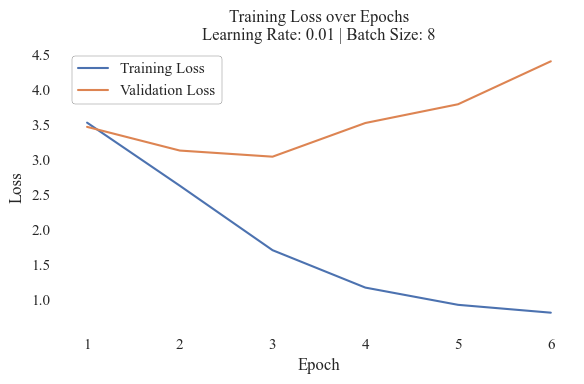

In [210]:
nn_bills_state = training_loop(token2index_bills, train_loader_bills_state, val_loader_bills_state, d=700, h=700, batch_size = 8, num_epochs = 1500, learning_rate = 0.01, n_classes = state_label_length )

In [211]:
predictions_bills_state, test_targets_bills_state, accuracy_bills_state, precision_bills_state, recall_bills_state, f1_bills_state = evaluation(nn_bills_state, test_loader_bills_state)

accuracy: 0.046012269938650305
precision: 0.017930419124053076
recall: 0.016348113223113223
f1: 0.015691172196341866


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


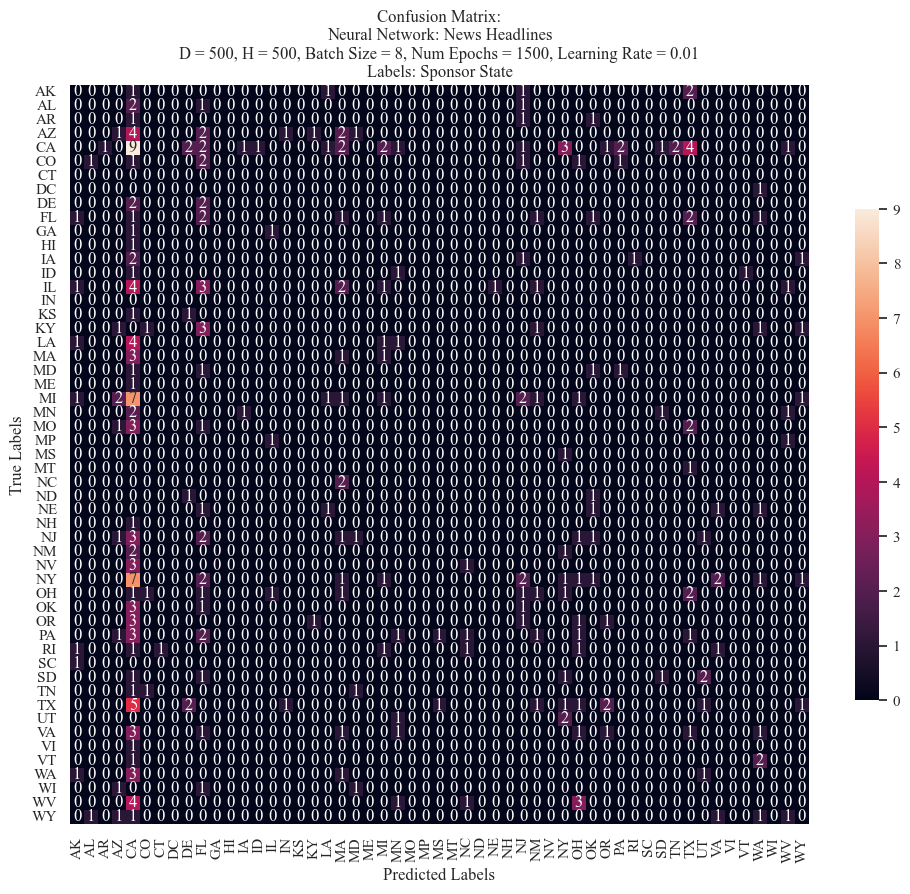

In [209]:
visual_confusion_matrix(test_targets_bills_state, predictions_bills_state, 'Neural Network: News Headlines\nD = 700, H = 700, Batch Size = 8, Num Epochs = 1500, Learning Rate = 0.01', 'Sponsor State', 'nn - bills - state.png', 10,10)

## 4. Predicting the Validation Sets

In [55]:
def validation(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            test_inputs, test_targets = batch
            test_outputs = model(test_inputs)
            predictions = (test_outputs.view(-1) >= 0.5).long()

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(test_targets.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)

    print(f'accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1: {f1}')

    return (all_predictions, all_targets, accuracy, precision, recall, f1)


### 4.1 News Data

In [57]:
predictions_news, test_targets_news, accuracy_news, precision_news, recall_news, f1_news = validation(nn_news, val_loader_news)

accuracy: 0.524390243902439
precision: 0.5625
recall: 0.4186046511627907
f1: 0.48


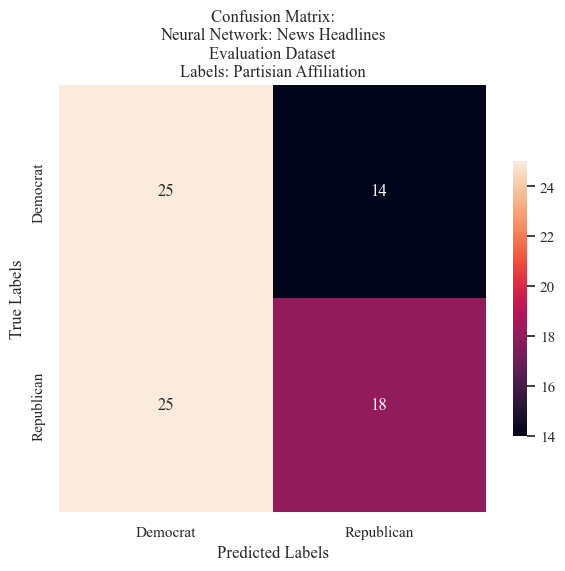

In [59]:
visual_confusion_matrix(test_targets_news, predictions_news,'Neural Network: News Headlines\nEvaluation Dataset', 'Partisian Affiliation', 'nn - news validation cm.png', 6,6)

### 4.2 Bills Data: Partisian Affiliation

In [88]:

def multiclass_validation(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            test_inputs, test_targets = batch

            test_outputs = model(test_inputs) 
            predictions = torch.argmax(test_outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(test_targets.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    print(f'accuracy: {accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1: {f1}')

    return (all_predictions, all_targets, accuracy, precision, recall, f1)


In [90]:
predictions_bills_party, test_targets_bills_party, accuracy_bills_party, precision_bills_party, recall_bills_party, f1_bills_party = multiclass_validation(nn_bills_party, val_loader_bills_party)

accuracy: 0.7614678899082569
precision: 0.5074209883010302
recall: 0.5126705653021443
f1: 0.5098250455184058


C:\Users\natal\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


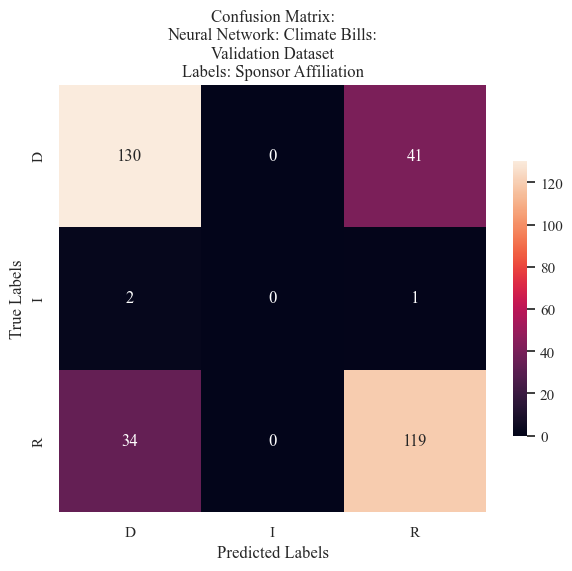

In [91]:
visual_confusion_matrix(test_targets_bills_party, predictions_bills_party, 'Neural Network: Climate Bills:\nValidation Dataset', 'Sponsor Affiliation', 'nn - bills - party - validation cm.png', 6,6)